# Import Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
import glob
import os

import sys
import itertools
from matplotlib import rcParams

import pastas
import pastas as ps

import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

import folium
from folium.plugins import MarkerCluster


import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

import wellapplication as wa

rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors

https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [2]:
pastas.__version__

'0.13.0'

In [3]:
codepath = "G:/My Drive/Python/GitHub/Leland Harris Analysis/"
sys.path.append(codepath)
import utils

In [4]:
#llpath = "E:/My Drive/Python/Pycharm/loggerloader/"
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

In [5]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn_ugs()

In [6]:
#file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"

# Define Functions

In [7]:
def calc_wat_year(df):
  df.loc[:,'month'] = df.index.month
  df.loc[:,'year'] = df.index.year
  df.loc[:,'doy'] = df.index.dayofyear
  
  df['water year'] = df.index.shift(-9,freq='M').year+1
  df['ones'] = 1
  df['water year doy'] = df['ones'].groupby(df['water year']).cumsum()
  df['doylen'] = df['ones'].groupby(df['water year']).count()
  df['water year doy1'] = df.apply(lambda df: df['doy']-273 if df['water year'] > df['year'] else df['doy']+92,1)
  return df


In [8]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

In [9]:
def plotlystuff(datasets, colnames, chrttypes=None, datatitles=None, chrttitle = 'well', colors=None,
                two_yaxes = False, axisdesig= None, axislabels=['Levels','Barometric Pressure']):
    
    if chrttypes is None:
        chrttypes = ['lines']*len(datasets)
    
    if datatitles is None:
        datatitles = colnames
    
    if axisdesig is None:
        axisdesig = ['y1']*len(datasets)
        
    if colors is None:
        if len(datasets) <= 5: 
            colors = ['#228B22','#F7DC6F','#FF1493','#663399','#FF0000']
        else:
            colors = []
            for i in range(len(datasets)):
                colors[i] = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
        
    r = lambda: random.randint(0,255)
    
    modetypes = ['markers','lines+markers','lines']
    datum = {}
    
    for i in range(len(datasets)):
        datum['d' + str(i)] = go.Scatter(
            x=datasets[i].index,
            y=datasets[i][colnames[i]],
            name = datatitles[i],
            line = dict(color = colors[i]),
            mode = chrttypes[i],
            opacity = 0.8,
            yaxis = axisdesig[i])
        
    data = list(datum.values())

    layout = dict(
        title=chrttitle,
        xaxis=dict(
            rangeslider=dict(
                visible = True
            ),
            type='date',
            tickformat='%Y-%m-%d %H:%M'
        ),
        yaxis=dict(title=axislabels[0],
                   titlefont=dict(color='#1f77b4'),
                   tickfont=dict(color='#1f77b4')),
    )
    
    
    if two_yaxes:
        layout['yaxis2'] = dict(title=axislabels[1], titlefont=dict(color='#ff7f0e'),
                    tickfont=dict(color='#ff7f0e'),
                    anchor='x',
                    overlaying='y',
                    side='right',
                    position=0.15)

    fig = dict(data=data, layout=layout)
    iplot(fig, filename = 'well')
    return 

In [10]:
def plot_joint_plot(verif, x='yhat', y='y', title=None, fpath = '../figures/paper', fname = None): 
    """
    
    Parameters
    ---------- 
    verif : pandas.DataFrame 
    x : string 
        The variable on the x-axis
        Defaults to `yhat`, i.e. the forecast or estimated values.
    y : string 
        The variable on the y-axis
        Defaults to `y`, i.e. the observed values
    title : string 
        The title of the figure, default `None`. 
    
    fpath : string 
        The path to save the figures, default to `../figures/paper`
    fname : string
        The filename for the figure to be saved
        ommits the extension, the figure is saved in png, jpeg and pdf
 
    Returns
    -------
    f : matplotlib Figure object
    """

    g = sns.jointplot(x='yhat', y='y', data = verif, kind="reg", color="0.4")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    fudge = verif.yhat.std()/2
    ax.set_xlim([verif.yhat.min()-fudge, verif.yhat.max()+fudge])
    ax.set_ylim([verif.y.min()-fudge, verif.y.max()+fudge])

    ax.text(verif.yhat.min(), verif.y.max()-fudge, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    return g

In [11]:
def plot_verif(verif, year=2017):
    
    verif.index = pd.to_datetime(verif.index)
    f, ax = plt.subplots(figsize=(14, 8))

    train = verif.loc[:str(year - 1),:]

    ax.plot(train.index, train.y, 'ko', markersize=3)

    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)

    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)

    test = verif.loc[str(year):,:]

    ax.plot(test.index, test.y, 'ro', markersize=3)

    ax.plot(test.index, test.yhat, color='coral', lw=0.5)

    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)

    ax.axvline(pd.to_datetime(str(year),format='%Y'), color='0.8', alpha=0.7)

    ax.grid(ls=':', lw=0.5)

    return f

def plot_verif_component(verif, component='rain', year=2017): 
    """
    plots a specific component of the `verif` DataFrame
   Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package. 
    component : string 
        The name of the component (i.e. column name) to plot in the `verif` DataFrame. 
    year : integer
        The year used to separate the training and test set. Default 2017
    Returns
    -------
    f : matplotlib Figure object
    """
    verif.index = pd.to_datetime(verif.index)
    f, ax = plt.subplots(figsize=(14, 7))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component] * 100, color='0.8', lw=1, ls='-')
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'] * 100, train.loc[:, component+'_upper'] * 100, color='0.8', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component] * 100, color='k', lw=1, ls='-')
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'] * 100, test.loc[:, component+'_upper'] * 100, color='0.8', alpha=0.3)
    
    ax.axvline(pd.to_datetime(str(year),format='%Y'), color='k', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

# Import and Merge Data

In [12]:
ugs_clim_raw_dly = pd.read_pickle(file_place + "ugs_clim_dly.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
wls = pd.read_pickle(file_place+"raw_hydrograph_data.pickle")
st_mt_df = pd.read_pickle(file_place+'climate_station_metadata1.pickle')
wls_piv = pd.read_pickle(file_place+"pivotedwells.pickle")
prismloc = pd.read_pickle(file_place+'prism_local_SG25.pickle')

In [13]:
climate_data['cdm_ppt'] = climate_data['PRISM_ppt _mm'].apply(lambda x: x- climate_data['PRISM_ppt _mm'].mean(),1).cumsum()
wls_daily = wls_piv.resample('1D').mean()

In [14]:
trout_creek = "https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10172870"
flow_data = wa.nwis('dv',[10172870],'sites')
trout = flow_data.data
trt = trout.rename(columns={'value':'trout'})['trout'].to_frame().resample('1D').mean().interpolate(method='time')


connection successful


In [15]:
comb_data = pd.concat([wls_daily,climate_data,trt],axis=1)

comb_data['Wheeler_swe_ft'] = comb_data['Wheeler_swe_mm']*0.00328084
comb_data['partoun_et_ft'] = comb_data['partoun_et']*0.00328084
comb_data['partoun_ppt_ft'] = comb_data['partoun_ppt']*0.00328084
comb_data['recharge'] = comb_data['Wheeler_swe_ft'] - comb_data['partoun_et_ft']
comb_data = comb_data['2010-10-01':'2019-08-07']

C:\Users\paulinkenbrandt\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



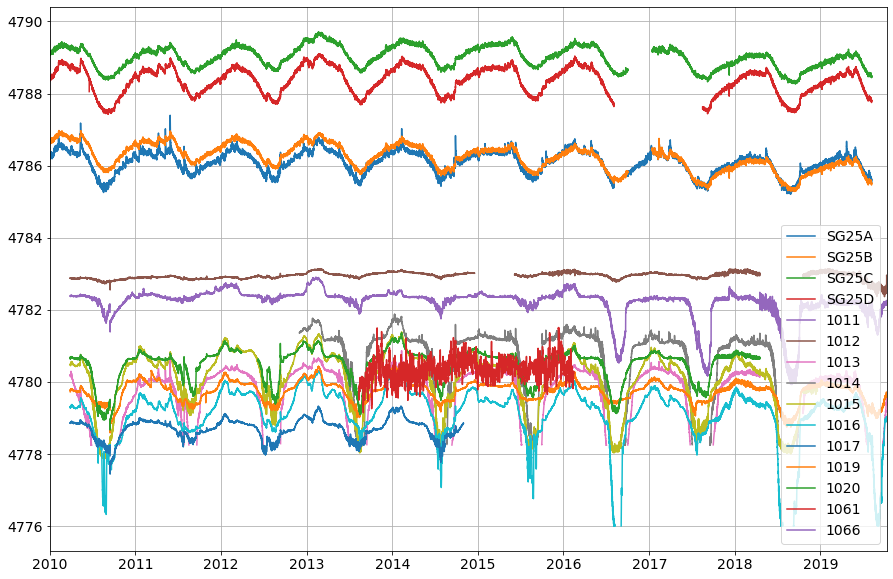

In [16]:

for col in wls_piv:
    if 'wle' in col:
        plt.plot(wls_piv.index,wls_piv[col],label=col.split('_')[0])
plt.legend()
tickdates = pd.date_range(wls_piv.first_valid_index(),wls_piv.last_valid_index(),freq='1YS')
plt.xlim(wls_piv.first_valid_index(),wls_piv.last_valid_index())
plt.xticks(tickdates,[datetime.datetime.strftime(i,'%Y') for i in tickdates])
plt.grid()

In [17]:
comb_data.columns

Index(['SG25A_wle', 'SG25A_t', 'SG25B_wle', 'SG25B_t', 'SG25C_wle', 'SG25C_t',
       'SG25D_wle', 'SG25D_t', '1011_t', '1011_wle', '1012_t', '1012_wle',
       '1013_t', '1013_wle', '1014_t', '1014_wle', '1015_t', '1015_wle',
       '1016_t', '1016_wle', '1017_t', '1017_wle', '1019_t', '1019_wle',
       '1020_t', '1020_wle', '1061_t', '1061_wle', '1066_t', '1066_wle',
       'callao_ppt', 'callao_snowdpt', 'callao_snowfall', 'callao_mintemp',
       'callao_maxtemp', 'callao_et', 'eskdale_ppt', 'eskdale_snowdpt',
       'eskdale_snowfall', 'eskdale_mintemp', 'eskdale_maxtemp', 'eskdale_et',
       'partoun_ppt', 'partoun_snowdpt', 'partoun_snowfall', 'partoun_mintemp',
       'partoun_maxtemp', 'partoun_et', 'brimstone_mintemp',
       'brimstone_maxtemp', 'brimstone_et', 'cedar_mintemp', 'cedar_maxtemp',
       'cedar_et', 'mather_mintemp', 'mather_maxtemp', 'mather_et',
       'tule_mintemp', 'tule_maxtemp', 'tule_et', 'Takka_pptaccm_mm',
       'Takka_pptincr_mm', 'Takka_snowdepth

In [18]:
print(models['SG25A_wle'].)

SyntaxError: invalid syntax (<ipython-input-18-60b6c132b6ac>, line 1)

# Temp Model

INFO: Inferred frequency from time series SG25A_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25A_wle: freq=D 
INFO: Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


SG25A_wle
Model Results SG25A_wle                 Fit Statistics
nfev     25                     EVP              72.15
nobs     3175                   R2                0.72
noise    True                   RMSE              0.16
tmin     2010-10-01 00:00:00    AIC               7.14
tmax     2019-08-07 00:00:00    BIC              37.46
freq     D                      ___                   
warmup   3650 days 00:00:00     ___                   
solver   LeastSquares           ___                   

Parameters (5 were optimized)
                 optimal     stderr      initial  vary
temp_A         -0.106220   ±499.96%    -0.083425  True
temp_n          0.374823     ±5.09%     1.000000  True
temp_a       4999.999997  ±1339.88%    10.000000  True
constant_d   4786.088336     ±0.00%  4786.107236  True
noise_alpha    35.584064    ±16.42%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a      (-1.0, 0.86, -0.85)
       constant_d  (-1.0, 0.86, -0.85)
temp_a constant_d  (

INFO: Inferred frequency from time series SG25B_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25B_wle: freq=D 
INFO: Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25A_wle is: 72.14751752524462
SG25B_wle
Model Results SG25B_wle                Fit Statistics
nfev     42                     EVP             43.13
nobs     3131                   R2               0.40
noise    True                   RMSE             0.27
tmin     2010-10-01 00:00:00    AIC             10.18
tmax     2019-08-07 00:00:00    BIC             40.42
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
temp_A         -0.065969  ±305.47%    -0.083425  True
temp_n          0.370765    ±5.29%     1.000000  True
temp_a       4999.996805  ±826.23%    10.000000  True
constant_d   4786.143612    ±0.00%  4786.212407  True
noise_alpha   609.013895   ±70.64%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-1.0)
Well SG25B_wle has r s

INFO: Inferred frequency from time series SG25C_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25C_wle: freq=D 
INFO: Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25B_wle is: 43.128204749446056
SG25C_wle
Model Results SG25C_wle                Fit Statistics
nfev     30                     EVP             11.67
nobs     3131                   R2               0.12
noise    True                   RMSE             0.28
tmin     2010-10-01 00:00:00    AIC             10.30
tmax     2019-08-07 00:00:00    BIC             40.54
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
temp_A         -0.004334   ±93.10%    -0.083425  True
temp_n          0.100000   ±49.79%     1.000000  True
temp_a       4207.138837  ±835.54%    10.000000  True
constant_d   4789.015873    ±0.00%  4789.013644  True
noise_alpha   536.676840   ±57.26%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.9)
Well SG25C_wle has r 

INFO: Inferred frequency from time series SG25D_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25D_wle: freq=D 
INFO: Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25C_wle is: 11.666434132631199
SG25D_wle
Model Results SG25D_wle                Fit Statistics
nfev     30                     EVP             66.27
nobs     2856                   R2               0.66
noise    True                   RMSE             0.21
tmin     2010-10-01 00:00:00    AIC             10.34
tmax     2019-08-07 00:00:00    BIC             40.13
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
temp_A         -0.123355  ±317.53%    -0.083425  True
temp_n          0.472558    ±3.36%     1.000000  True
temp_a       2875.115282  ±676.83%    10.000000  True
constant_d   4788.340007    ±0.00%  4788.363947  True
noise_alpha   244.474577   ±36.02%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a      (-1.0, 0.54, -0.54)
    

INFO: Inferred frequency from time series 1011_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1011_wle: freq=D 
INFO: Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25D_wle is: 66.26648020835677
1011_wle
Model Results 1011_wle                Fit Statistics
nfev     24                     EVP            29.27
nobs     3231                   R2              0.29
noise    True                   RMSE            0.37
tmin     2010-10-01 00:00:00    AIC             7.89
tmax     2019-08-07 00:00:00    BIC            38.30
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.023625  ±14.80%    -0.083425  True
temp_n          0.906905   ±7.85%     1.000000  True
temp_a         32.521872  ±31.18%    10.000000  True
constant_d   4782.248017   ±0.00%  4782.220601  True
noise_alpha   289.714252  ±41.52%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.62, -0.76)
temp_n temp_a  (-0.62, -0.76)


INFO: Inferred frequency from time series 1012_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1012_wle: freq=D 
INFO: Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1011_wle is: 29.270921600687462
1012_wle
Model Results 1012_wle                Fit Statistics
nfev     37                     EVP            32.54
nobs     2880                   R2              0.33
noise    True                   RMSE            0.06
tmin     2010-10-01 00:00:00    AIC            13.72
tmax     2019-08-07 00:00:00    BIC            43.54
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.004889  ±15.21%    -0.083425  True
temp_n          1.054982  ±10.14%     1.000000  True
temp_a         22.827858  ±32.61%    10.000000  True
constant_d   4782.959412   ±0.00%  4782.961621  True
noise_alpha   156.032526  ±34.71%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.54, -0.79)
temp_n temp_a  (-0.54, -0.79)


INFO: Inferred frequency from time series 1013_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1013_wle: freq=D 
INFO: Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1012_wle is: 32.53956302789025
1013_wle
Model Results 1013_wle                Fit Statistics
nfev     16                     EVP            28.38
nobs     2481                   R2              0.25
noise    True                   RMSE            0.41
tmin     2010-10-25 00:00:00    AIC             7.23
tmax     2019-07-17 00:00:00    BIC            36.32
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.067479   ±7.15%    -0.083425  True
temp_n          1.094637   ±4.92%     1.000000  True
temp_a         30.276462  ±14.63%    10.000000  True
constant_d   4779.668883   ±0.00%  4779.996845  True
noise_alpha   220.405895  ±34.89%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.52, -0.77)
temp_n temp_a  (-0.52, -0.77)
W

INFO: Inferred frequency from time series 1014_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1014_wle: freq=D 
INFO: Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1013_wle is: 28.382853164288314
1014_wle
Model Results 1014_wle                Fit Statistics
nfev     15                     EVP            47.81
nobs     1842                   R2              0.21
noise    True                   RMSE            0.66
tmin     2012-12-01 00:00:00    AIC             6.61
tmax     2018-09-30 00:00:00    BIC            34.20
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.083334   ±8.92%    -0.083425  True
temp_n          1.142559   ±6.46%     1.000000  True
temp_a         26.257488  ±18.44%    10.000000  True
constant_d   4780.324765   ±0.01%  4780.877503  True
noise_alpha   326.633834  ±56.23%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.51, -0.78)
temp_n temp_a  (-0.51, -0.78)


INFO: Inferred frequency from time series 1015_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1015_wle: freq=D 
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1014_wle is: 47.80658671220773
1015_wle
Model Results 1015_wle                Fit Statistics
nfev     29                     EVP            68.51
nobs     3001                   R2              0.68
noise    True                   RMSE            0.44
tmin     2010-10-01 00:00:00    AIC             7.31
tmax     2018-12-18 00:00:00    BIC            37.35
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.058307   ±7.54%    -0.083425  True
temp_n          1.037736   ±4.58%     1.000000  True
temp_a         30.256671  ±15.36%    10.000000  True
constant_d   4780.152045   ±0.00%  4780.116434  True
noise_alpha   263.112794  ±40.34%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.59, -0.77)
temp_n temp_a  (-0.59, -0.77)
W

INFO: Inferred frequency from time series 1016_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1016_wle: freq=D 
INFO: Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1015_wle is: 68.5130125329642
1016_wle
Model Results 1016_wle                Fit Statistics
nfev     13                     EVP            52.15
nobs     3158                   R2              0.52
noise    True                   RMSE            0.43
tmin     2010-10-01 00:00:00    AIC             5.48
tmax     2019-08-07 00:00:00    BIC            35.77
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.054388  ±10.87%    -0.083425  True
temp_n          1.165191   ±8.23%     1.000000  True
temp_a         26.268516  ±23.08%    10.000000  True
constant_d   4779.183772   ±0.00%  4779.218120  True
noise_alpha   172.965219  ±30.80%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.52, -0.78)
temp_n temp_a  (-0.52, -0.78)
We

INFO: Inferred frequency from time series 1017_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1017_wle: freq=D 
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1016_wle is: 52.14900162143115
1017_wle
Model Results 1017_wle                Fit Statistics
nfev     26                     EVP            74.11
nobs     1492                   R2              0.73
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            10.98
tmax     2014-10-31 00:00:00    BIC            37.52
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.021169  ±10.44%    -0.083425  True
temp_n          0.941573   ±8.13%     1.000000  True
temp_a         32.166788  ±25.74%    10.000000  True
constant_d   4778.743299   ±0.00%  4778.714660  True
noise_alpha    46.518230  ±18.75%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.51, -0.77)
temp_n temp_a  (-0.51, -0.77)
W

INFO: Inferred frequency from time series 1019_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1019_wle: freq=D 
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1017_wle is: 74.1133287683719
1019_wle
Model Results 1019_wle                Fit Statistics
nfev     26                     EVP            75.55
nobs     3233                   R2              0.75
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            10.59
tmax     2019-08-07 00:00:00    BIC            40.99
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.023315   ±6.08%    -0.083425  True
temp_n          1.299325   ±5.72%     1.000000  True
temp_a         21.710324  ±13.66%    10.000000  True
constant_d   4779.777135   ±0.00%  4779.764937  True
noise_alpha    98.865559  ±19.57%     1.000000  True

Parameter correlations |rho| > 0.5
temp_n temp_a  (-0.8)
Well 1019_wle has r squared =
0.75228278

INFO: Inferred frequency from time series 1020_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1020_wle: freq=D 
INFO: Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1019_wle is: 75.5537986703889
1020_wle
Model Results 1020_wle                Fit Statistics
nfev     27                     EVP            62.11
nobs     2687                   R2              0.60
noise    True                   RMSE            0.26
tmin     2010-10-01 00:00:00    AIC             8.81
tmax     2018-04-17 00:00:00    BIC            38.29
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
temp_A         -0.029117   ±9.38%    -0.083425  True
temp_n          1.007028   ±6.05%     1.000000  True
temp_a         24.977000  ±20.22%    10.000000  True
constant_d   4780.571607   ±0.00%  4780.529677  True
noise_alpha   107.194942  ±21.75%     1.000000  True

Parameter correlations |rho| > 0.5
temp_A temp_a  (-0.55, -0.78)
temp_n temp_a  (-0.55, -0.78)
We

INFO: Inferred frequency from time series 1061_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1061_wle: freq=D 
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1020_wle is: 62.11345591135085
1061_wle
Model Results 1061_wle                  Fit Statistics
nfev     33                     EVP               0.05
nobs     918                    R2                0.00
noise    True                   RMSE              0.29
tmin     2013-08-10 00:00:00    AIC               3.30
tmax     2016-02-13 00:00:00    BIC              27.41
freq     D                      ___                   
warmup   3650 days 00:00:00     ___                   
solver   LeastSquares           ___                   

Parameters (5 were optimized)
                 optimal     stderr      initial  vary
temp_A         -0.000418   ±597.12%    -0.083425  True
temp_n          7.171067  ±3486.65%     1.000000  True
temp_a          1.438017  ±3775.61%    10.000000  True
constant_d   4780.358198     ±0.00%  4780.355303  True
noise_alpha     4.158043    ±10.75%     1.000000  True

Parameter correlations |rho| > 0.5
temp_n temp_a  (-0.97)
Well 106

INFO: Inferred frequency from time series 1066_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1066_wle: freq=D 
INFO: Time Series 1066_wle: 3233 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1066_wle: 3233 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_maxtemp: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_maxtemp: freq=D 
INFO: Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_maxtemp: 73 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1061_wle is: 0.052445140758861086
1066_wle
1066_wle failed


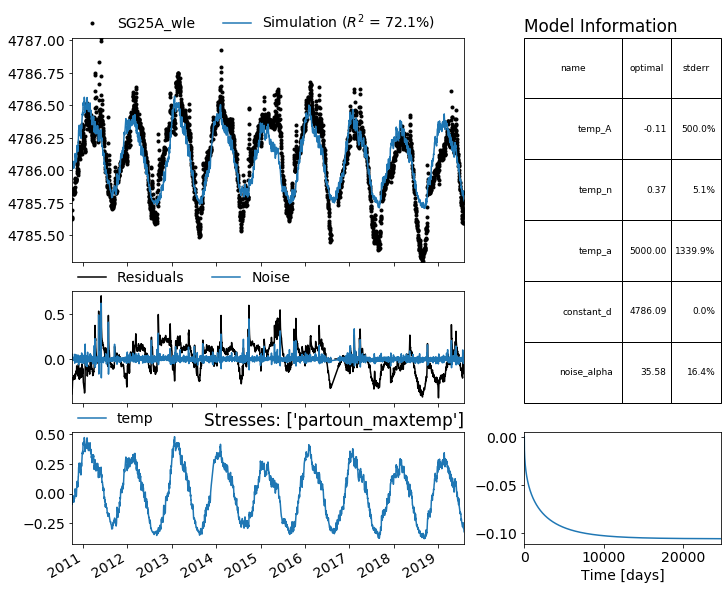

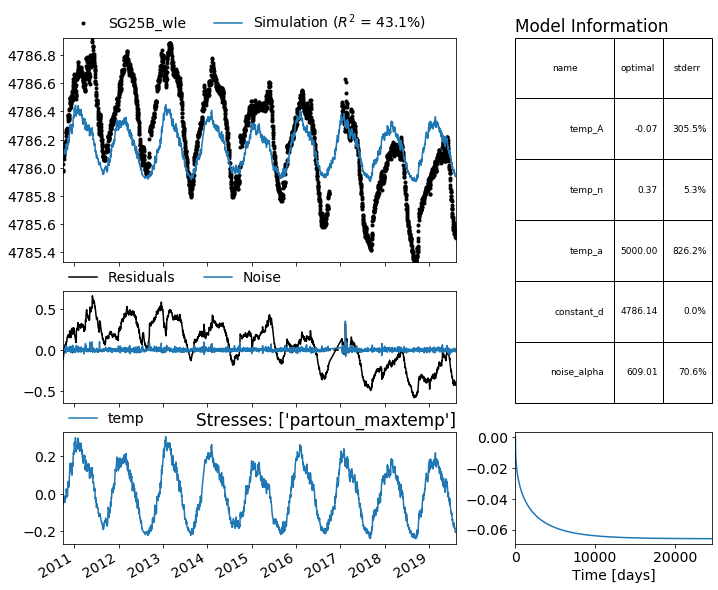

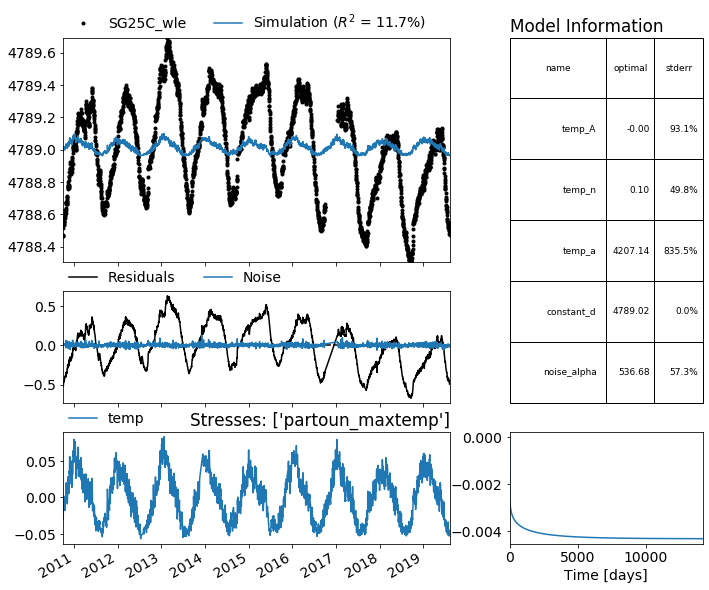

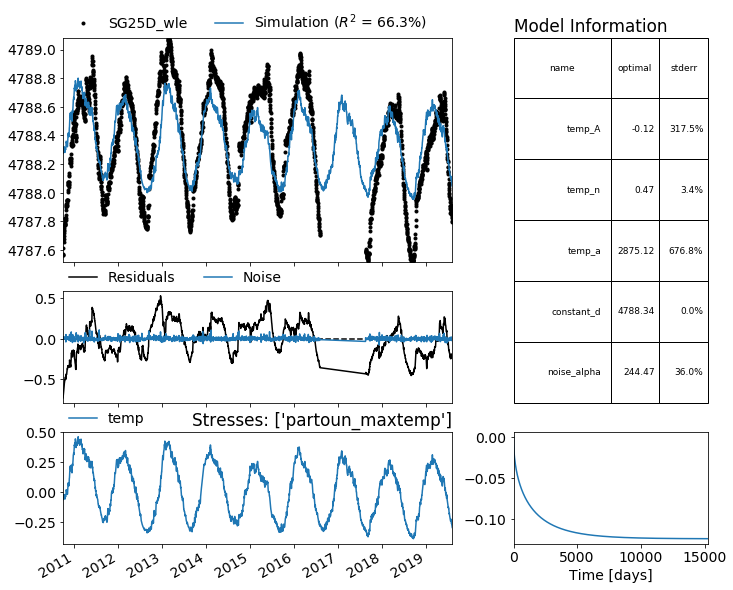

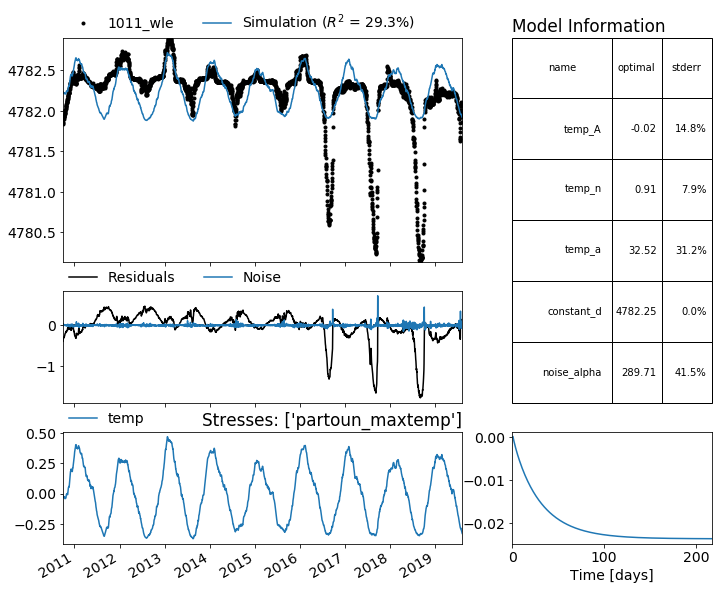

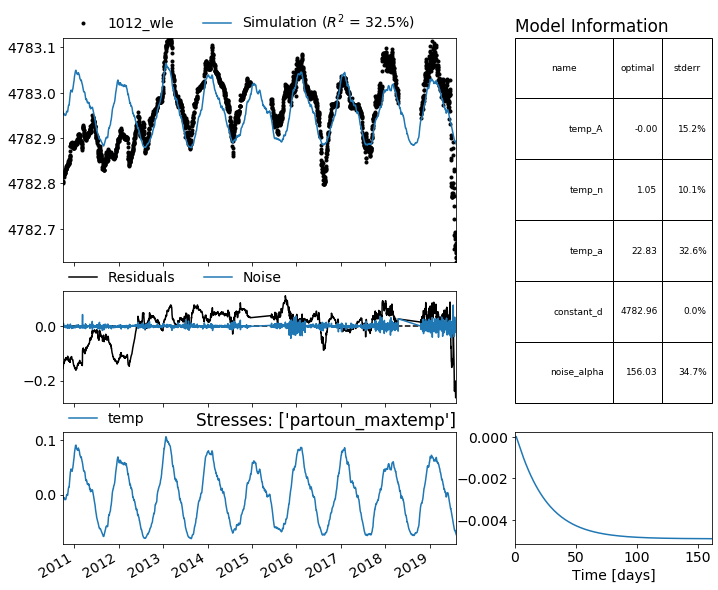

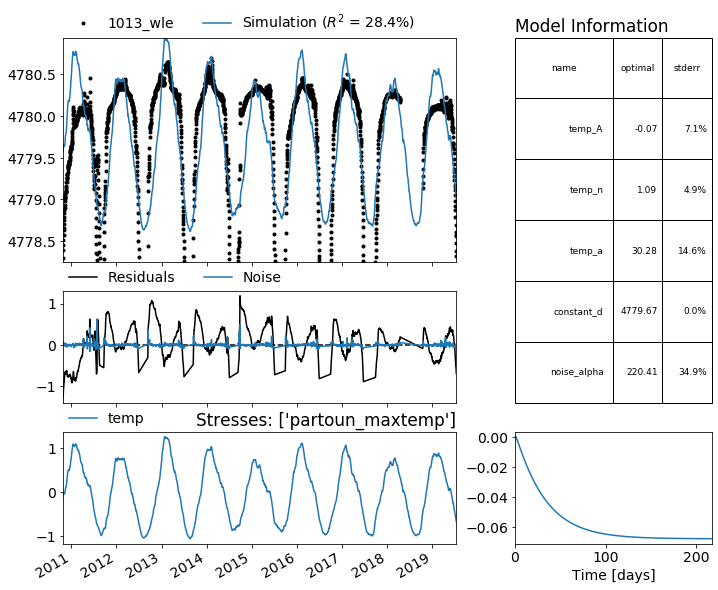

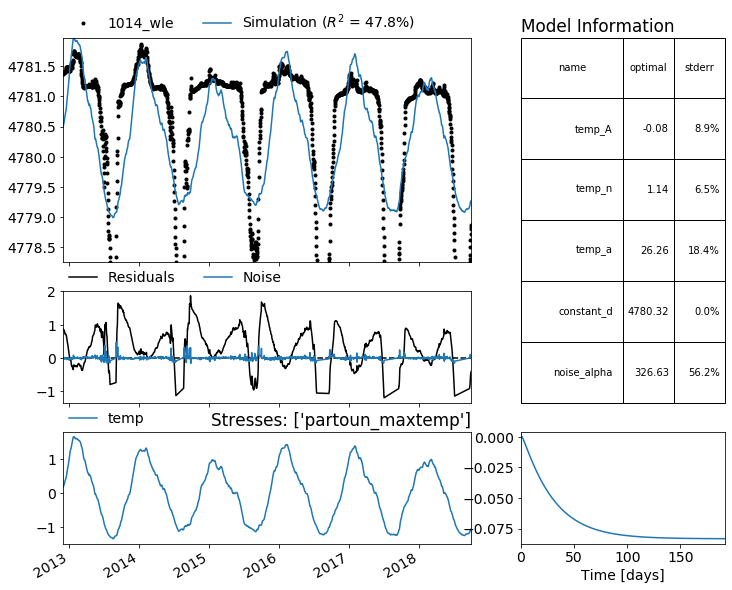

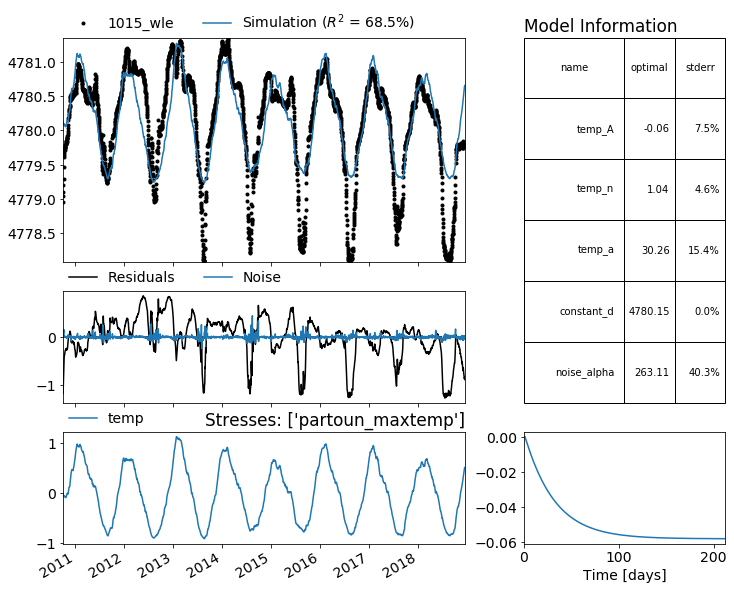

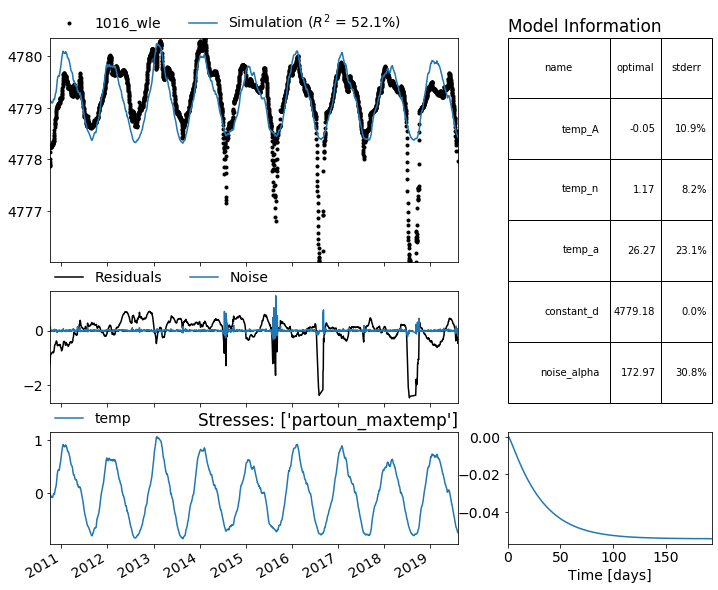

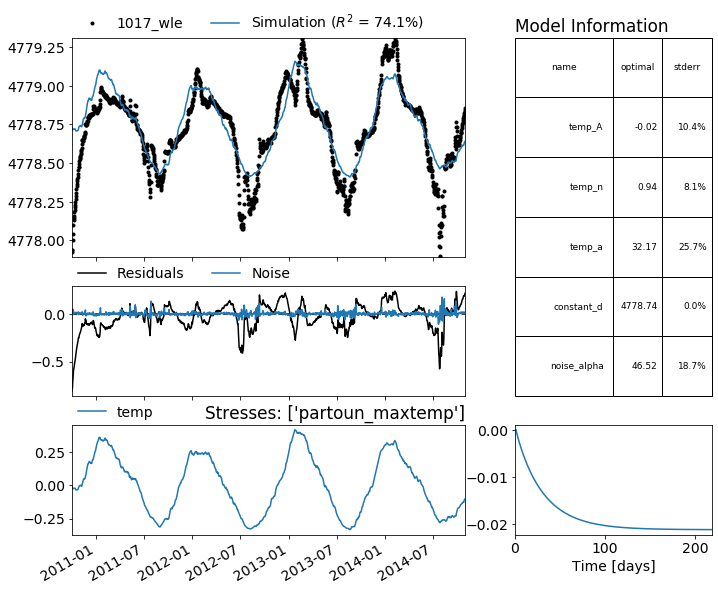

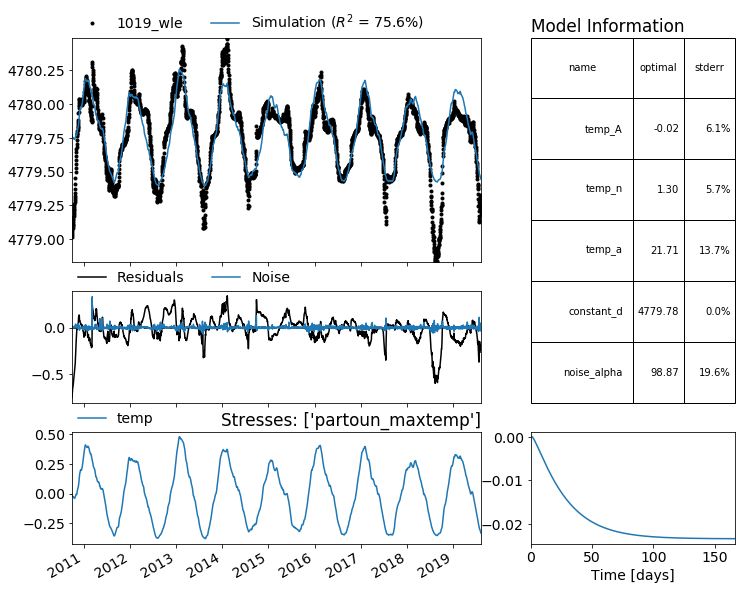

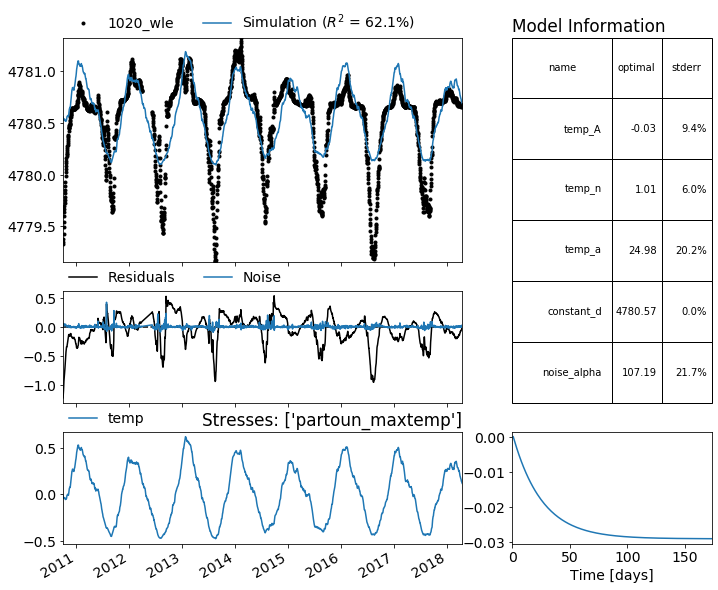

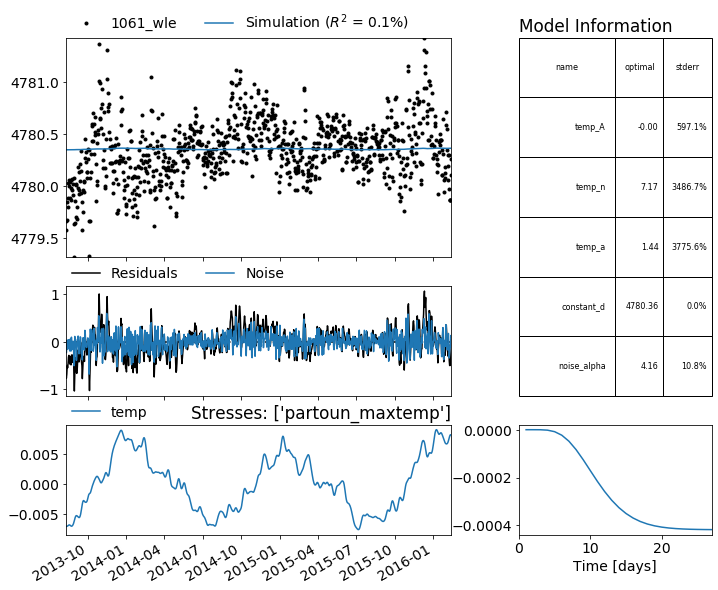

In [26]:
models = {}
for col in comb_data.columns:
    if "_wle" in col:
        ml = ps.Model(comb_data[col])
        tmp = ps.StressModel(comb_data['partoun_maxtemp'], up=False, rfunc=ps.Gamma,  name="temp")
        #pr = ps.StressModel(comb_data['partoun_ppt_ft'], ps.Gamma, name='prec')
        ml.add_stressmodel(tmp)
        tmp.update_stress(norm="mean")
        #ml.add_stressmodel(pr)
        print(col)
        try:
            ml.solve()
            ml.plots.results()
            print(f'Well {col} has r squared =')
            print(ml.stats.rsq_adj())

            plt.savefig(file_place + f"PASTAS_tmp_{col}")
            #plt.close()
            evp = ml.stats.evp()
            models[col] = ml
            print(f"The explained variance percentage in {col} is: {evp}")
        except:
            print(f"{col} failed")

In [29]:
models['1020_wle'].stats.bic()

38.287186590242214

In [30]:
print(models['1020_wle'].stats.aic())
print(models['1020_wle'].stats.rmse())

8.806283547164755
0.2571938126931394


# ET Model

INFO: Inferred frequency from time series SG25A_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25A_wle: freq=D 
INFO: Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


Model Results SG25A_wle               Fit Statistics
nfev     42                     EVP            71.94
nobs     3175                   R2              0.72
noise    True                   RMSE            0.16
tmin     2010-10-01 00:00:00    AIC             6.76
tmax     2019-08-07 00:00:00    BIC            37.07
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -40.856044  ±12.64%  -124.575444  True
et_rho          1.849569  ±58.35%     1.000000  True
et_cS          45.437399  ±58.76%   100.000000  True
constant_d   4786.576200   ±0.00%  4786.107236  True
noise_alpha    28.737488  ±13.45%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.79, -0.82, -0.95, -0.99, -0.75, 0.77)
       et_cS       (0.79, -0.82, -0.95, -0.99, -0.75, 0.77)
       constant_d 

INFO: Inferred frequency from time series SG25B_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25B_wle: freq=D 
INFO: Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25A_wle is: 71.9365871525866
Model Results SG25B_wle               Fit Statistics
nfev     38                     EVP            48.19
nobs     3131                   R2              0.48
noise    True                   RMSE            0.25
tmin     2010-10-01 00:00:00    AIC             9.54
tmax     2019-08-07 00:00:00    BIC            39.78
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -41.381930  ±13.77%  -124.575444  True
et_rho          1.595860  ±39.61%     1.000000  True
et_cS          58.424688  ±45.84%   100.000000  True
constant_d   4786.676597   ±0.00%  4786.212407  True
noise_alpha   332.989928  ±47.17%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho  (0.75, -0.8, -0.98)
       et_cS   (0.75, -0.8, -0.98)


INFO: Inferred frequency from time series SG25C_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25C_wle: freq=D 
INFO: Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25B_wle is: 48.188763029674654
Model Results SG25C_wle                Fit Statistics
nfev     52                     EVP             60.63
nobs     3131                   R2               0.60
noise    True                   RMSE             0.19
tmin     2010-10-01 00:00:00    AIC             10.08
tmax     2019-08-07 00:00:00    BIC             40.33
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A          -64.580457   ±36.27%  -124.575444  True
et_rho          0.617217   ±68.64%     1.000000  True
et_cS         239.883559  ±110.62%   100.000000  True
constant_d   4789.779072    ±0.01%  4789.013644  True
noise_alpha   177.411859   ±30.16%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.96, -0.98, -0.98, -0.99, -0.94,

INFO: Inferred frequency from time series SG25D_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25D_wle: freq=D 
INFO: Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25C_wle is: 60.62936820587728
Model Results SG25D_wle               Fit Statistics
nfev     34                     EVP            72.66
nobs     2856                   R2              0.73
noise    True                   RMSE            0.19
tmin     2010-10-01 00:00:00    AIC             9.71
tmax     2019-08-07 00:00:00    BIC            39.49
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -61.886001  ±13.27%  -124.575444  True
et_rho          1.228901  ±34.24%     1.000000  True
et_cS          84.375489  ±42.07%   100.000000  True
constant_d   4789.088938   ±0.00%  4788.363947  True
noise_alpha   120.385393  ±23.83%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.85, -0.89, -0.91, -0.98, -0.76, 0.8)
       et_

INFO: Inferred frequency from time series 1011_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1011_wle: freq=D 
INFO: Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25D_wle is: 72.66341874903559
Model Results 1011_wle                  Fit Statistics
nfev     36                     EVP              29.72
nobs     3231                   R2                0.29
noise    True                   RMSE              0.37
tmin     2010-10-01 00:00:00    AIC               7.92
tmax     2019-08-07 00:00:00    BIC              38.32
freq     D                      ___                   
warmup   3650 days 00:00:00     ___                   
solver   LeastSquares           ___                   

Parameters (5 were optimized)
                 optimal     stderr      initial  vary
et_A          -57.680220   ±156.09%  -124.575444  True
et_rho          0.017128   ±656.71%     1.000000  True
et_cS        9976.517035  ±1312.55%   100.000000  True
constant_d   4782.883535     ±0.01%  4782.220601  True
noise_alpha   289.653750    ±42.25%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (1.0, -1.0, -0.94, -

INFO: Inferred frequency from time series 1012_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1012_wle: freq=D 
INFO: Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1011_wle is: 29.717716014198302
Model Results 1012_wle                 Fit Statistics
nfev     32                     EVP             29.17
nobs     2880                   R2               0.29
noise    True                   RMSE             0.06
tmin     2010-10-01 00:00:00    AIC             13.72
tmax     2019-08-07 00:00:00    BIC             43.55
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A          -12.340559   ±52.42%  -124.575444  True
et_rho          0.036335  ±179.72%     1.000000  True
et_cS        3385.233488  ±358.23%   100.000000  True
constant_d   4783.101924    ±0.00%  4782.961621  True
noise_alpha   162.469811   ±35.44%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.96, -0.97, -0.94, -1.0, -0.89, 0

INFO: Inferred frequency from time series 1013_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1013_wle: freq=D 
INFO: Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1012_wle is: 29.16762916160076
Model Results 1013_wle                 Fit Statistics
nfev     60                     EVP             33.82
nobs     2481                   R2               0.33
noise    True                   RMSE             0.39
tmin     2010-10-25 00:00:00    AIC              7.36
tmax     2019-07-17 00:00:00    BIC             36.44
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A         -246.817723   ±62.26%  -124.575444  True
et_rho          0.027203  ±234.68%     1.000000  True
et_cS        9999.997833  ±468.58%   100.000000  True
constant_d   4782.357625    ±0.02%  4779.996845  True
noise_alpha   155.754054   ±26.27%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (1.0, -1.0, -0.98, -1.0, -0.97, 0.97

INFO: Inferred frequency from time series 1014_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1014_wle: freq=D 
INFO: Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1013_wle is: 33.81843305561185
Model Results 1014_wle                  Fit Statistics
nfev     59                     EVP              57.00
nobs     1842                   R2                0.41
noise    True                   RMSE              0.57
tmin     2012-12-01 00:00:00    AIC               6.70
tmax     2018-09-30 00:00:00    BIC              34.29
freq     D                      ___                   
warmup   3650 days 00:00:00     ___                   
solver   LeastSquares           ___                   

Parameters (5 were optimized)
                 optimal     stderr      initial  vary
et_A         -319.456099   ±169.13%  -124.575444  True
et_rho          0.029531   ±624.31%     1.000000  True
et_cS        9999.999946  ±1246.82%   100.000000  True
constant_d   4783.841026     ±0.05%  4780.877503  True
noise_alpha   291.984647    ±56.97%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (1.0, -1.0, -0.99, -1

INFO: Inferred frequency from time series 1016_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1016_wle: freq=D 
INFO: Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1014_wle is: 57.00381471642382
Model Results 1016_wle                 Fit Statistics
nfev     58                     EVP             51.03
nobs     3158                   R2               0.51
noise    True                   RMSE             0.43
tmin     2010-10-01 00:00:00    AIC              5.51
tmax     2019-08-07 00:00:00    BIC             35.80
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A         -204.654120  ±107.27%  -124.575444  True
et_rho          0.029862  ±395.71%     1.000000  True
et_cS        9999.999778  ±789.96%   100.000000  True
constant_d   4781.415976    ±0.02%  4779.218120  True
noise_alpha   164.526804   ±30.17%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (1.0, -1.0, -0.98, -1.0, -0.97, 0.97

INFO: Inferred frequency from time series 1017_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1017_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1016_wle is: 51.032856662666504
Model Results 1017_wle                 Fit Statistics
nfev     25                     EVP             73.12
nobs     1492                   R2               0.72
noise    True                   RMSE             0.14
tmin     2010-10-01 00:00:00    AIC             11.08
tmax     2014-10-31 00:00:00    BIC             37.62
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A          -55.520191   ±84.79%  -124.575444  True
et_rho          0.038585  ±294.60%     1.000000  True
et_cS        2563.314519  ±587.19%   100.000000  True
constant_d   4779.384035    ±0.01%  4778.714660  True
noise_alpha    47.601203   ±18.32%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.99, -1.0, -1.0, -1.0, -0.99, 0.9

INFO: Inferred frequency from time series 1019_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1019_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1017_wle is: 73.12365496122017
Model Results 1019_wle                 Fit Statistics
nfev     31                     EVP             75.85
nobs     3233                   R2               0.75
noise    True                   RMSE             0.14
tmin     2010-10-01 00:00:00    AIC             10.62
tmax     2019-08-07 00:00:00    BIC             41.03
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A          -81.946051   ±41.63%  -124.575444  True
et_rho          0.030109  ±153.59%     1.000000  True
et_cS        9999.999964  ±306.35%   100.000000  True
constant_d   4780.667480    ±0.00%  4779.764937  True
noise_alpha    93.563821   ±18.33%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (0.99, -0.99, -0.97, -1.0, -0.94, 0.

INFO: Inferred frequency from time series 1020_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1020_wle: freq=D 
INFO: Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1019_wle is: 75.85149029983704
Model Results 1020_wle                 Fit Statistics
nfev     62                     EVP             67.47
nobs     2687                   R2               0.66
noise    True                   RMSE             0.24
tmin     2010-10-01 00:00:00    AIC              8.96
tmax     2018-04-17 00:00:00    BIC             38.44
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A         -115.124665   ±61.80%  -124.575444  True
et_rho          0.022005  ±245.08%     1.000000  True
et_cS        9999.993260  ±489.61%   100.000000  True
constant_d   4781.813151    ±0.01%  4780.529677  True
noise_alpha    93.639684   ±19.52%     1.000000  True

Parameter correlations |rho| > 0.5
et_A   et_rho      (1.0, -1.0, -0.98, -1.0, -0.97, 0.97

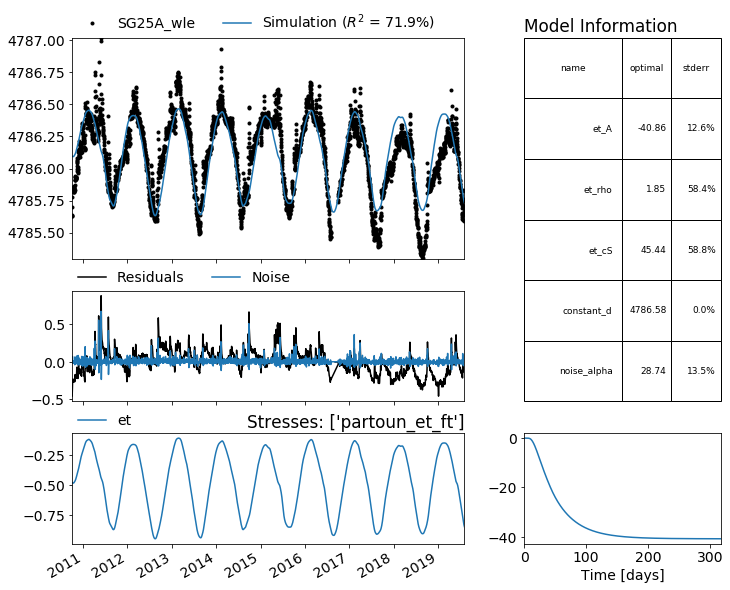

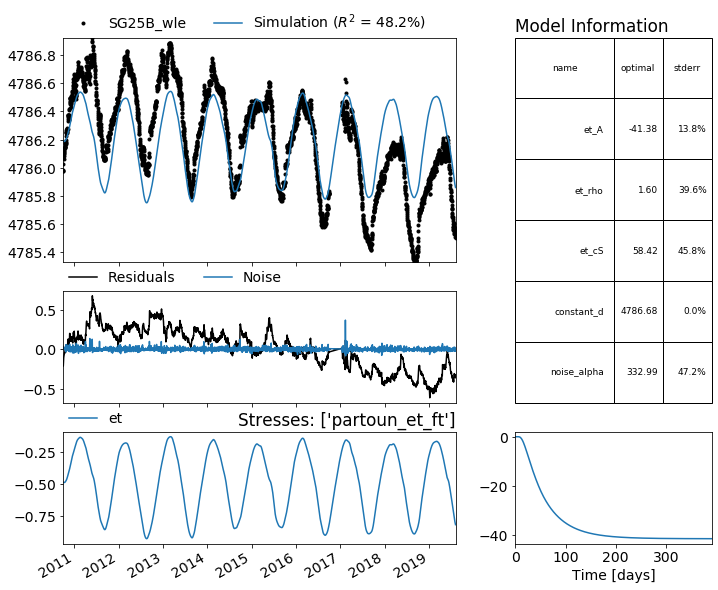

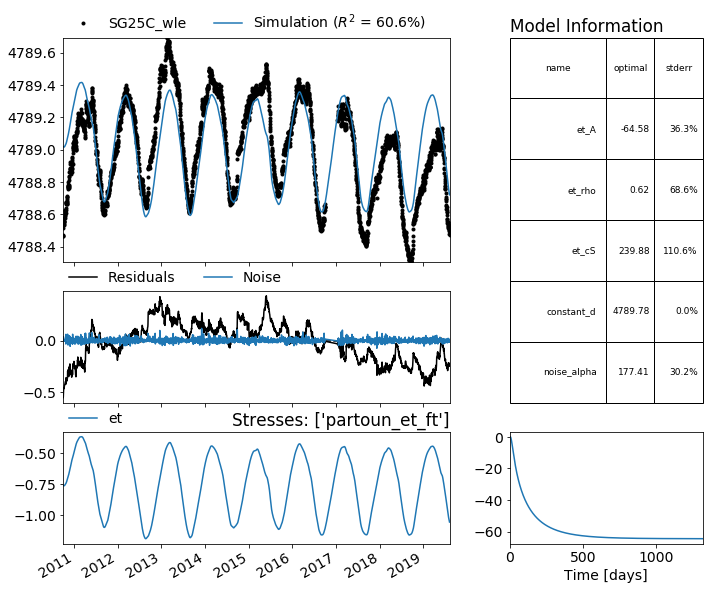

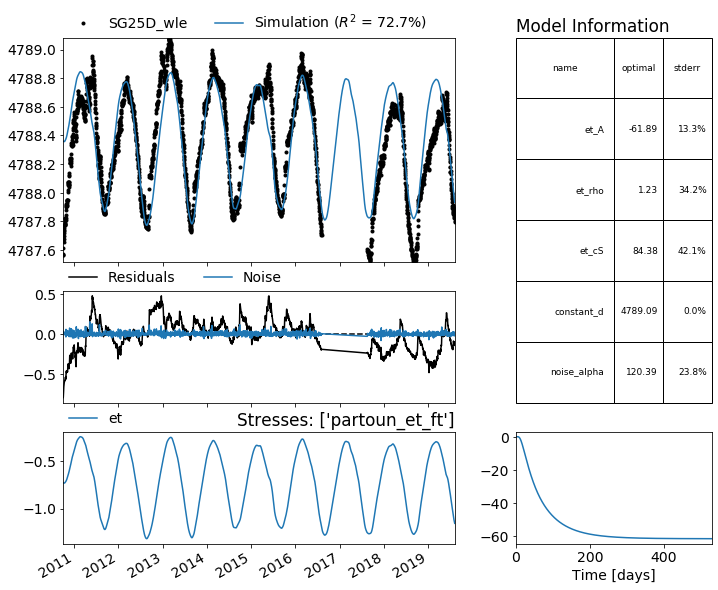

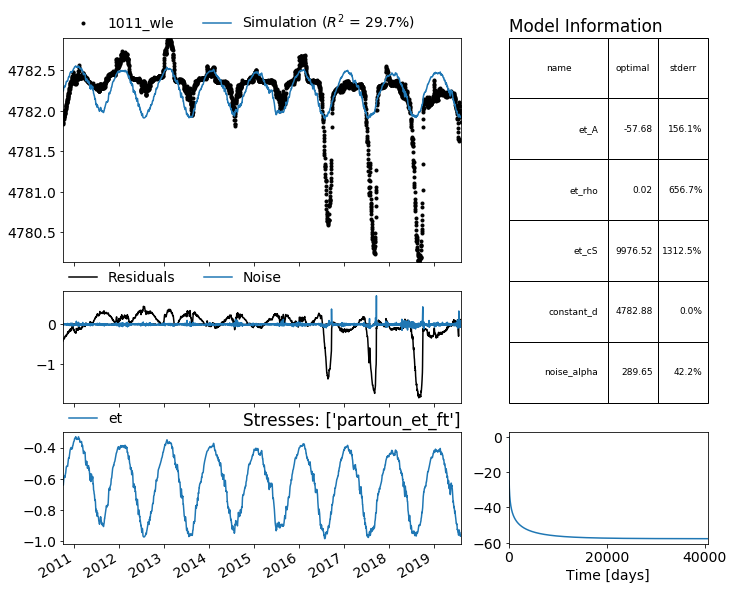

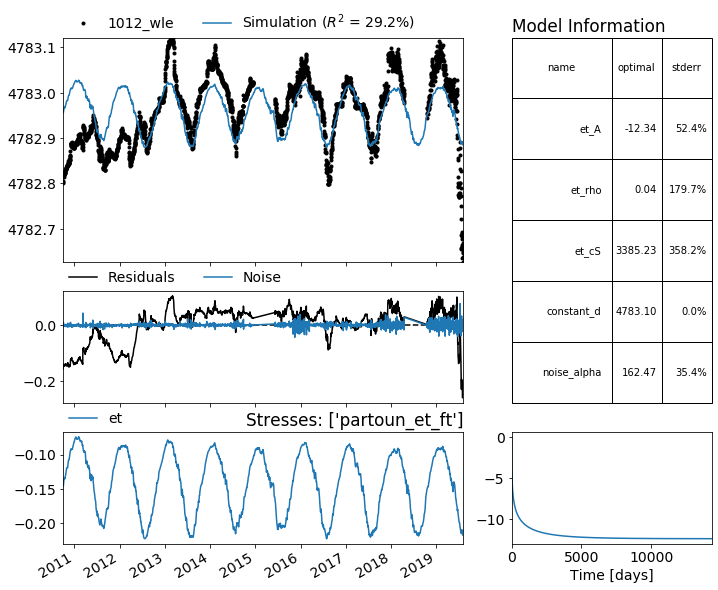

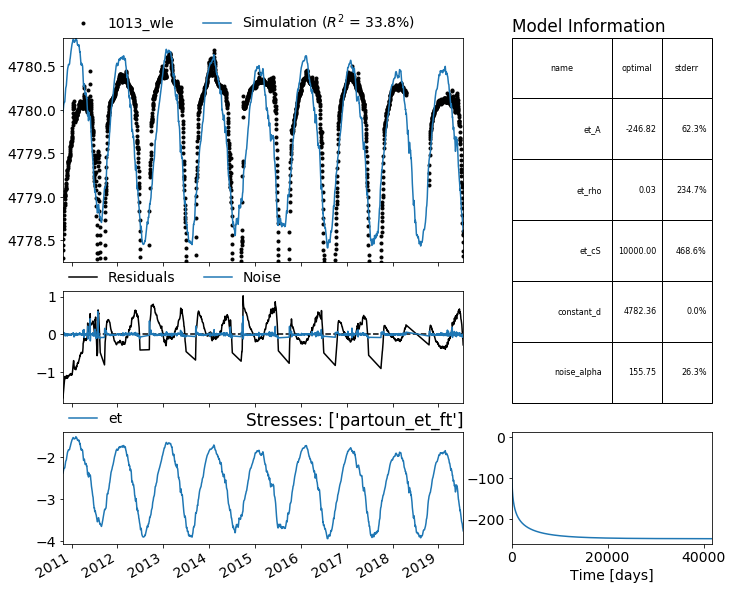

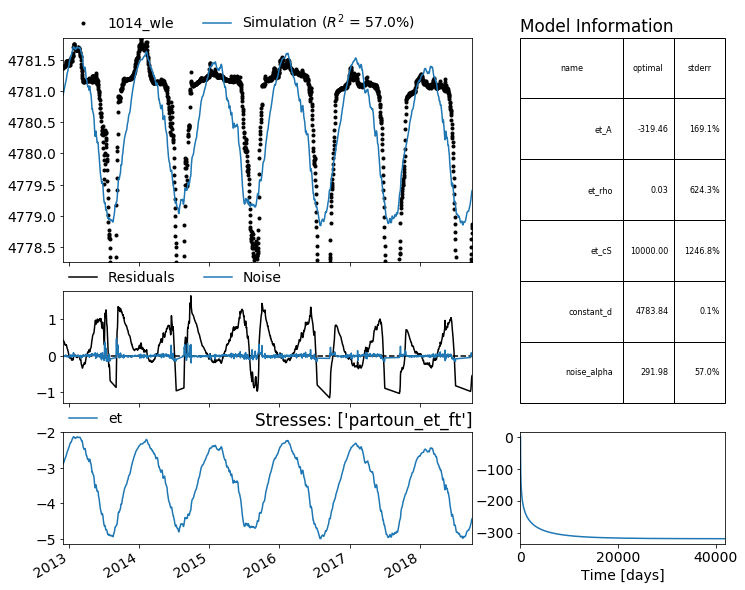

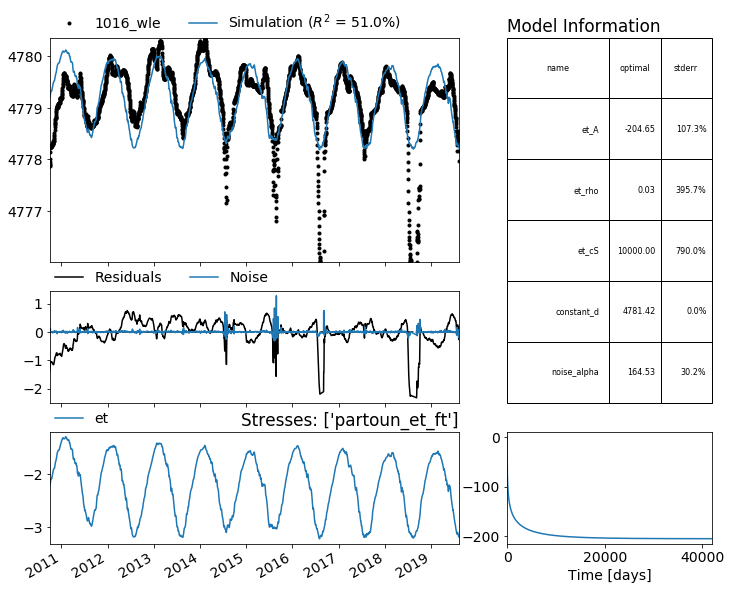

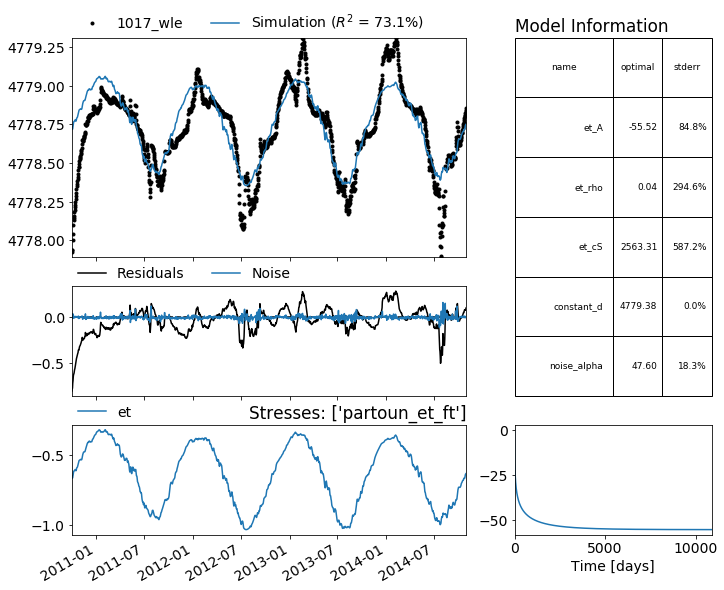

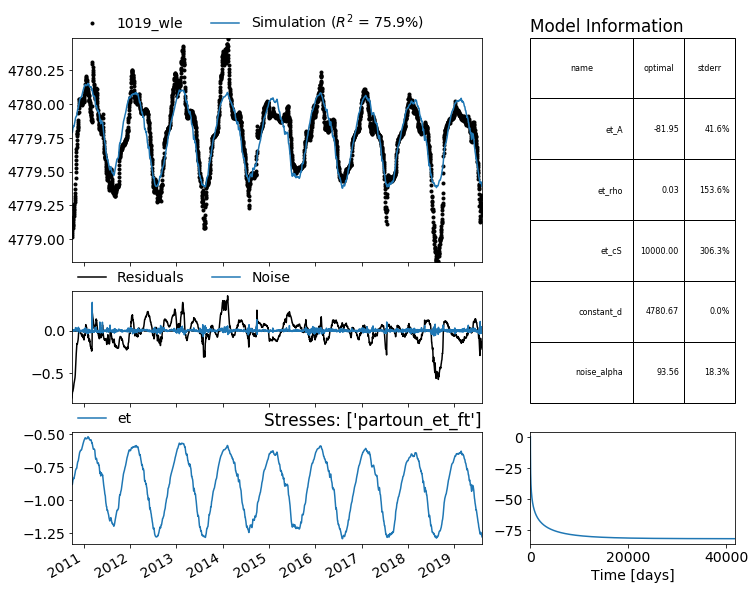

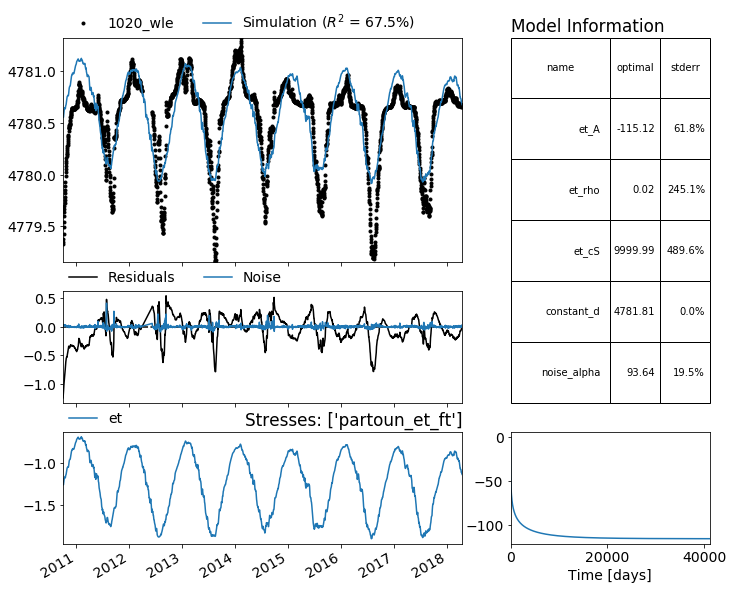

In [27]:
models = {}
for col in comb_data.columns:
    if "_wle" in col:
        ml = ps.Model(comb_data[col])
        et = ps.StressModel(comb_data['partoun_et_ft'], up=False, rfunc=ps.Hantush,  name="et", settings="evap")
        #pr = ps.StressModel(comb_data['partoun_ppt_ft'], ps.Gamma, name='prec')
        ml.add_stressmodel(et)
        #ml.add_stressmodel(pr)
        ml.solve()
        ml.plots.results()
        plt.savefig(file_place + f"PASTAS_et_{col}")
        #plt.close()
        evp = ml.stats.evp()
        models[col] = ml
        print(f"The explained variance percentage in {col} is: {evp}")


INFO: Inferred frequency from time series SG25A_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25A_wle: freq=D 
INFO: Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


Model Results SG25A_wle               Fit Statistics
nfev     19                     EVP            69.16
nobs     3175                   R2              0.69
noise    True                   RMSE            0.16
tmin     2010-10-01 00:00:00    AIC             7.07
tmax     2019-08-07 00:00:00    BIC            37.38
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -200.435790  ±15.01%  -124.575444  True
et_n            0.429525   ±4.08%     1.000000  True
et_a         2477.498468  ±35.12%    10.000000  True
constant_d   4788.363622   ±0.01%  4786.107236  True
noise_alpha    36.156813  ±16.37%     1.000000  True

Parameter correlations |rho| > 0.5
et_A et_a        (-0.66, -0.98, 0.51, 0.53)
     constant_d  (-0.66, -0.98, 0.51, 0.53)
et_n constant_d  (-0.66, -0.98, 0.51, 0.53)
et_a c

INFO: Inferred frequency from time series SG25B_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25B_wle: freq=D 
INFO: Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25A_wle is: 69.16449521292228
Model Results SG25B_wle               Fit Statistics
nfev     30                     EVP            81.53
nobs     3131                   R2              0.81
noise    True                   RMSE            0.15
tmin     2010-10-01 00:00:00    AIC             9.97
tmax     2019-08-07 00:00:00    BIC            40.22
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -386.167704  ±10.62%  -124.575444  True
et_n            0.533100   ±2.77%     1.000000  True
et_a         4999.999991  ±25.31%    10.000000  True
constant_d   4789.998343   ±0.01%  4786.212407  True
noise_alpha   109.259555  ±24.96%     1.000000  True

Parameter correlations |rho| > 0.5
et_A et_a        (-0.56, -0.82, -0.63, 0.71)
     constant_d  (-0.56,

INFO: Inferred frequency from time series SG25C_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25C_wle: freq=D 
INFO: Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25B_wle is: 81.52991042637744
Model Results SG25C_wle               Fit Statistics
nfev     30                     EVP            50.98
nobs     3131                   R2              0.49
noise    True                   RMSE            0.21
tmin     2010-10-01 00:00:00    AIC            10.23
tmax     2019-08-07 00:00:00    BIC            40.48
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -287.164866  ±22.52%  -124.575444  True
et_n            0.559206   ±3.60%     1.000000  True
et_a         4362.739595  ±43.00%    10.000000  True
constant_d   4791.920195   ±0.01%  4789.013644  True
noise_alpha   178.998723  ±29.00%     1.000000  True

Parameter correlations |rho| > 0.5
et_A et_a        (-0.79, -0.93, 0.52, 0.51)
     constant_d  (-0.79, 

INFO: Inferred frequency from time series SG25D_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25D_wle: freq=D 
INFO: Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25C_wle is: 50.97794923786781
Model Results SG25D_wle               Fit Statistics
nfev     25                     EVP            62.19
nobs     2856                   R2              0.60
noise    True                   RMSE            0.23
tmin     2010-10-01 00:00:00    AIC            10.17
tmax     2019-08-07 00:00:00    BIC            39.95
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -375.703636  ±19.30%  -124.575444  True
et_n            0.587054   ±2.26%     1.000000  True
et_a         2026.921374  ±32.45%    10.000000  True
constant_d   4792.632457   ±0.02%  4788.363947  True
noise_alpha   161.997217  ±28.29%     1.000000  True

Parameter correlations |rho| > 0.5
et_A et_a        (-0.89, -0.99, 0.85)
     constant_d  (-0.89, -0.99,

INFO: Inferred frequency from time series 1011_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1011_wle: freq=D 
INFO: Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in SG25D_wle is: 62.19345187697299
Model Results 1011_wle                Fit Statistics
nfev     24                     EVP            28.44
nobs     3231                   R2              0.27
noise    True                   RMSE            0.37
tmin     2010-10-01 00:00:00    AIC             7.92
tmax     2019-08-07 00:00:00    BIC            38.33
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -46.365269  ±13.22%  -124.575444  True
et_n            0.776907   ±6.88%     1.000000  True
et_a           46.035303  ±30.46%    10.000000  True
constant_d   4782.806092   ±0.00%  4782.220601  True
noise_alpha   298.671089  ±42.81%     1.000000  True

Parameter correlations |rho| > 0.5
et_A et_a  (-0.66, -0.74)
et_n et_a  (-0.66, -0.74)


INFO: Inferred frequency from time series 1012_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1012_wle: freq=D 
INFO: Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1011_wle is: 28.4446563560648
Model Results 1012_wle                 Fit Statistics
nfev     38                     EVP              0.00
nobs     2880                   R2              -0.14
noise    True                   RMSE             0.08
tmin     2010-10-01 00:00:00    AIC             13.70
tmax     2019-08-07 00:00:00    BIC             43.53
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (5 were optimized)
                 optimal    stderr      initial  vary
et_A          -58.416794   ±93.72%  -124.575444  True
et_n            0.681815    ±7.34%     1.000000  True
et_a         1617.031301  ±146.92%    10.000000  True
constant_d   4783.627570    ±0.01%  4782.961621  True
noise_alpha   246.696809   ±55.43%     1.000000  True

Parameter correlations |rho| > 0.5
et_A       et_a         (-0.96, -1.0, -0.61, 0.95, 0.64,

INFO: Inferred frequency from time series 1013_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1013_wle: freq=D 
INFO: Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1012_wle is: 0.0
Model Results 1013_wle                Fit Statistics
nfev     21                     EVP             0.00
nobs     2481                   R2             -0.09
noise    True                   RMSE            0.50
tmin     2010-10-25 00:00:00    AIC             7.43
tmax     2019-07-17 00:00:00    BIC            36.51
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -137.783814   ±5.24%  -124.575444  True
et_n            1.032754   ±4.24%     1.000000  True
et_a           30.170965  ±11.79%    10.000000  True
constant_d   4781.290823   ±0.00%  4779.996845  True
noise_alpha   199.038458  ±31.96%     1.000000  True

Parameter correlations |rho| > 0.5
et_A constant_d  (-0.56, -0.77)
et_n et_a        (-0.56, -0.77)


INFO: Inferred frequency from time series 1014_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1014_wle: freq=D 
INFO: Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1013_wle is: 0.0
Model Results 1014_wle                Fit Statistics
nfev     15                     EVP            26.31
nobs     1842                   R2              0.18
noise    True                   RMSE            0.68
tmin     2012-12-01 00:00:00    AIC             6.75
tmax     2018-09-30 00:00:00    BIC            34.34
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A         -167.513342   ±6.67%  -124.575444  True
et_n            1.083190   ±5.71%     1.000000  True
et_a           27.891763  ±15.40%    10.000000  True
constant_d   4782.384174   ±0.01%  4780.877503  True
noise_alpha   348.407602  ±62.17%     1.000000  True

Parameter correlations |rho| > 0.5
et_n et_a  (-0.77)


INFO: Inferred frequency from time series 1016_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1016_wle: freq=D 
INFO: Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1014_wle is: 26.30974631784039
Model Results 1016_wle                Fit Statistics
nfev     26                     EVP            40.89
nobs     3158                   R2              0.41
noise    True                   RMSE            0.47
tmin     2010-10-01 00:00:00    AIC             5.51
tmax     2019-08-07 00:00:00    BIC            35.80
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -98.338238   ±9.18%  -124.575444  True
et_n            1.114530   ±8.30%     1.000000  True
et_a           27.762449  ±21.91%    10.000000  True
constant_d   4780.358924   ±0.00%  4779.218120  True
noise_alpha   179.234485  ±32.19%     1.000000  True

Parameter correlations |rho| > 0.5
et_A constant_d  (-0.55, -0.78)
et_n et_a        (-0.55, -0.78)


INFO: Inferred frequency from time series 1017_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1017_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1016_wle is: 40.887913760312344
Model Results 1017_wle                Fit Statistics
nfev     26                     EVP            73.99
nobs     1492                   R2              0.73
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            11.07
tmax     2014-10-31 00:00:00    BIC            37.61
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -37.743062   ±8.71%  -124.575444  True
et_n            0.836111   ±7.16%     1.000000  True
et_a           35.161530  ±23.75%    10.000000  True
constant_d   4779.187206   ±0.00%  4778.714660  True
noise_alpha    45.660643  ±18.47%     1.000000  True

Parameter correlations |rho| > 0.5
et_A constant_d  (-0.85, -0.77)
et_n et_a        (-0.85, -0.77)


INFO: Inferred frequency from time series 1019_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1019_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1017_wle is: 73.98642200923875
Model Results 1019_wle                Fit Statistics
nfev     25                     EVP            74.04
nobs     3233                   R2              0.74
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            10.64
tmax     2019-08-07 00:00:00    BIC            41.05
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -40.203863   ±5.74%  -124.575444  True
et_n            1.058351   ±5.10%     1.000000  True
et_a           29.561629  ±13.95%    10.000000  True
constant_d   4780.253633   ±0.00%  4779.764937  True
noise_alpha   103.477783  ±20.27%     1.000000  True

Parameter correlations |rho| > 0.5
et_A constant_d  (-0.71, -0.77)
et_n et_a        (-0.71, -0.77)


INFO: Inferred frequency from time series 1020_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1020_wle: freq=D 
INFO: Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1019_wle is: 74.04082435694264
Model Results 1020_wle                Fit Statistics
nfev     17                     EVP            63.13
nobs     2687                   R2              0.61
noise    True                   RMSE            0.26
tmin     2010-10-01 00:00:00    AIC             8.94
tmax     2018-04-17 00:00:00    BIC            38.42
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (5 were optimized)
                 optimal   stderr      initial  vary
et_A          -55.101252   ±6.83%  -124.575444  True
et_n            1.066445   ±5.39%     1.000000  True
et_a           15.341338  ±16.11%    10.000000  True
constant_d   4781.216482   ±0.00%  4780.529677  True
noise_alpha   111.332744  ±23.87%     1.000000  True

Parameter correlations |rho| > 0.5
et_A constant_d  (-0.66, -0.81)
et_n et_a        (-0.66, -0.81)
The ex

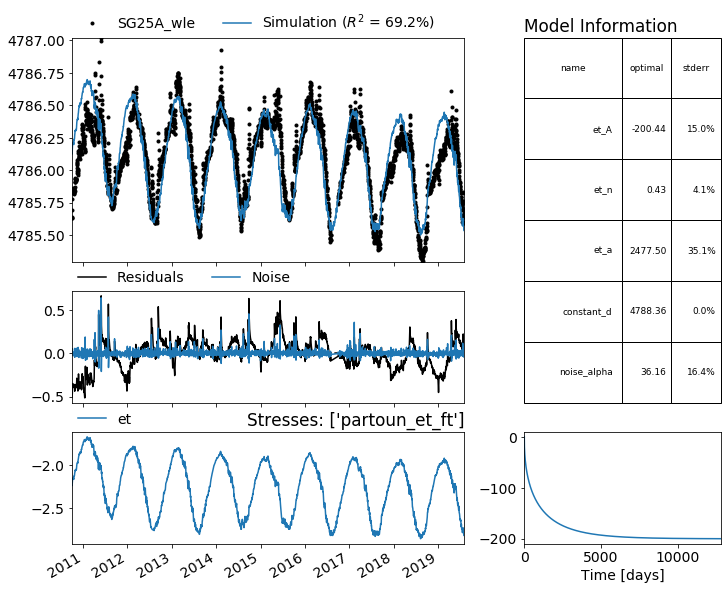

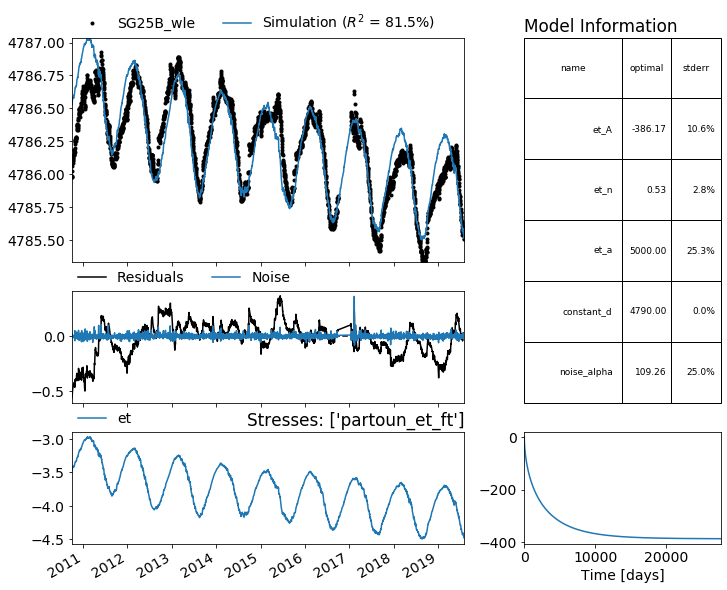

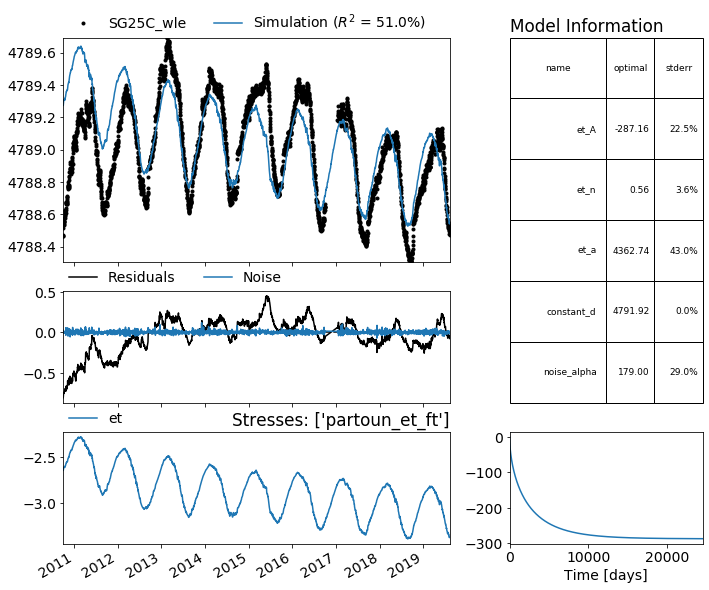

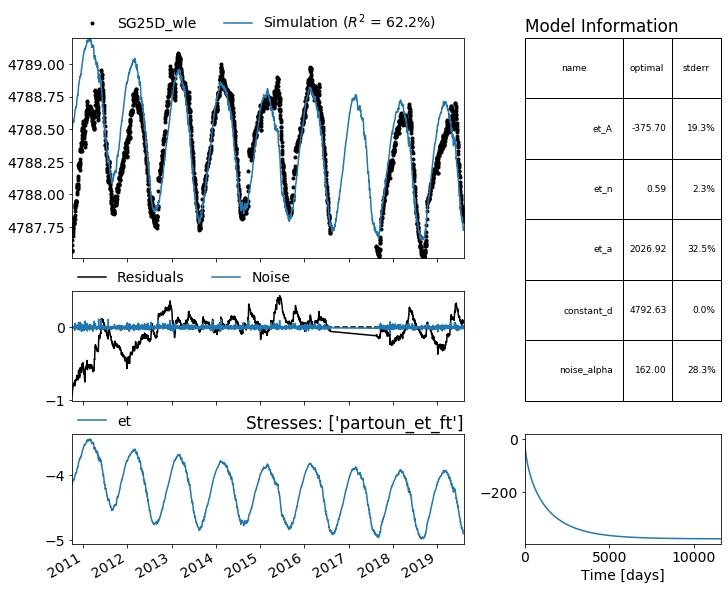

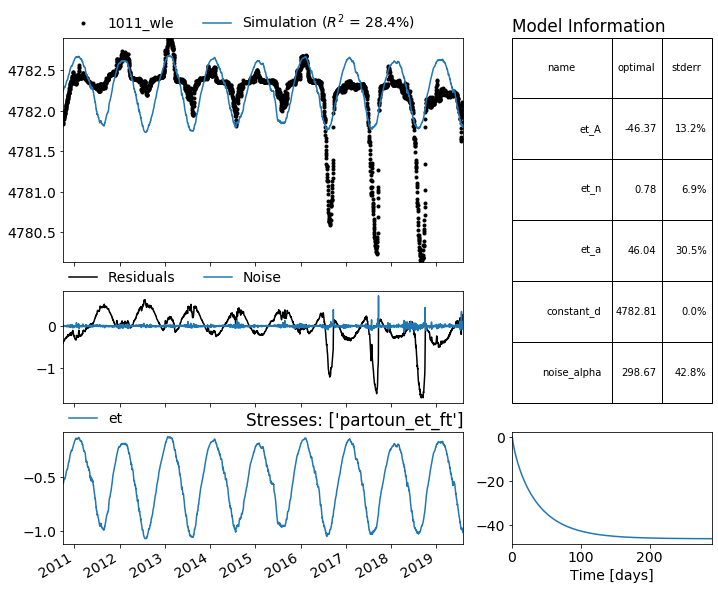

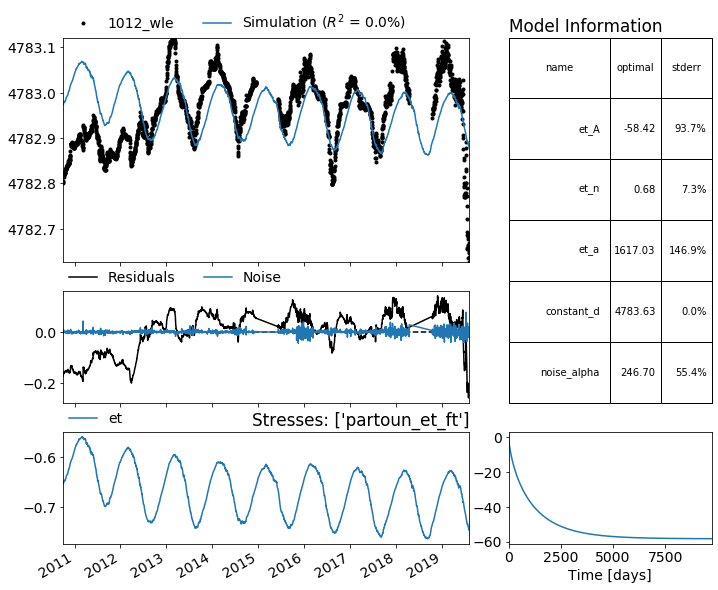

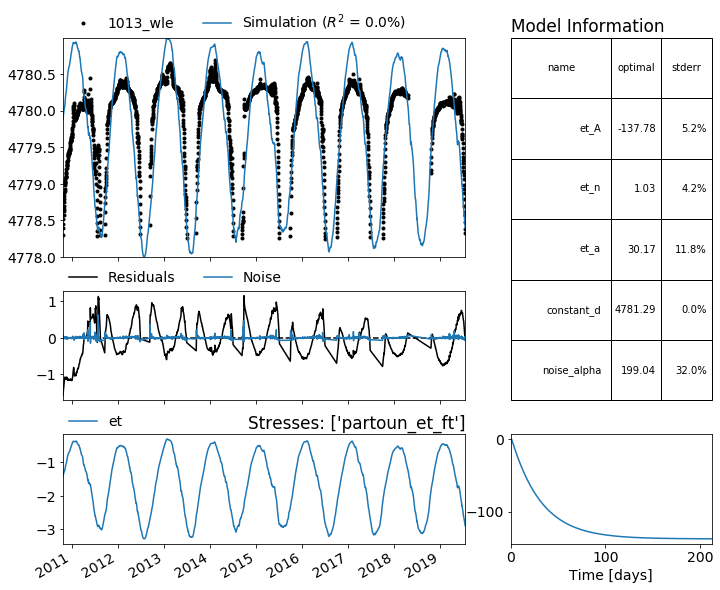

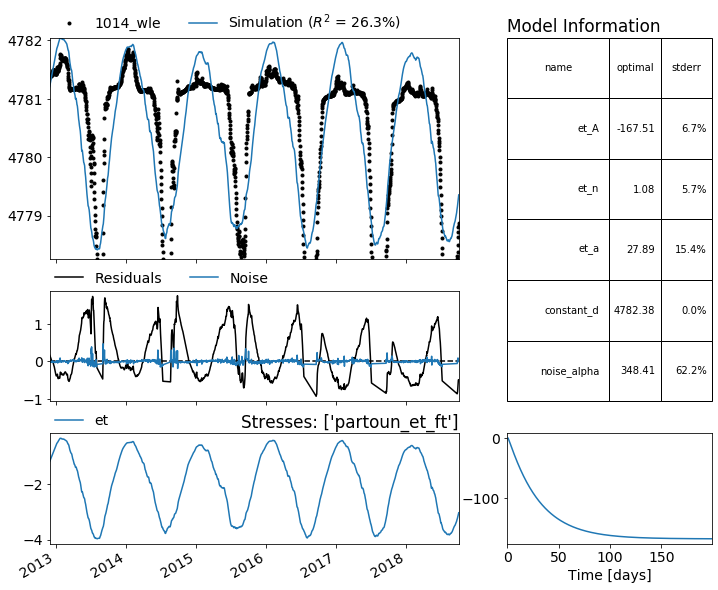

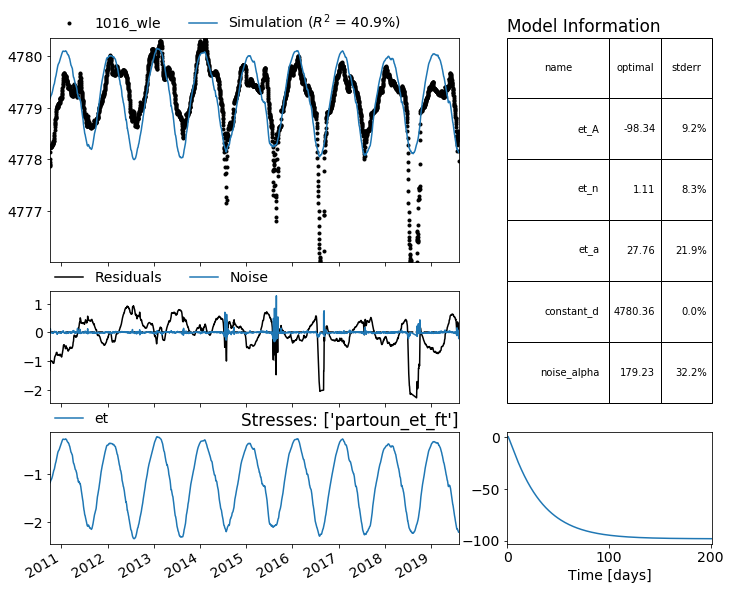

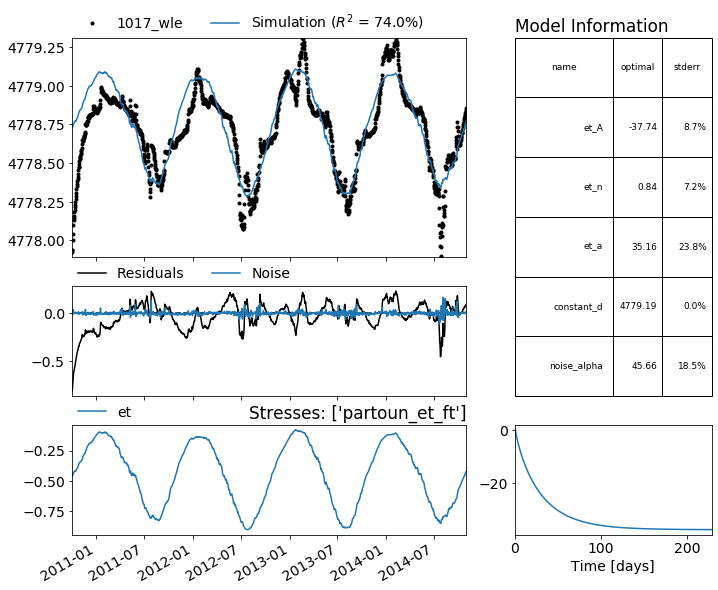

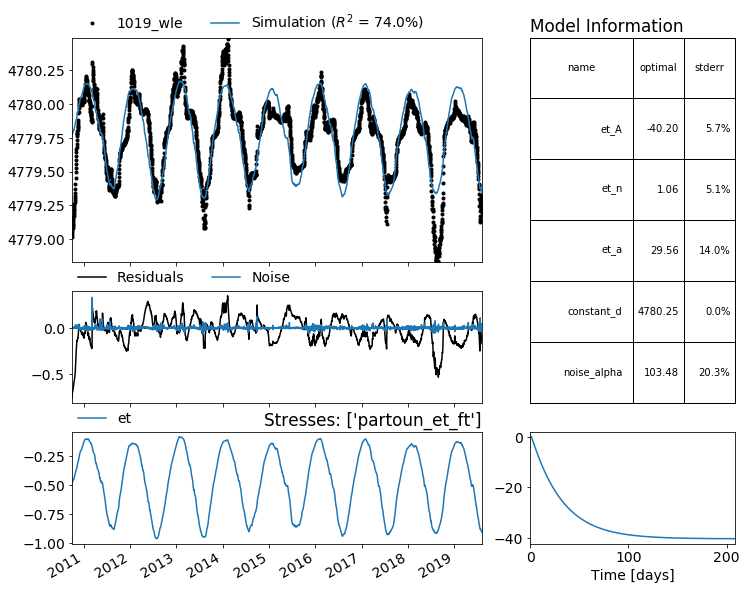

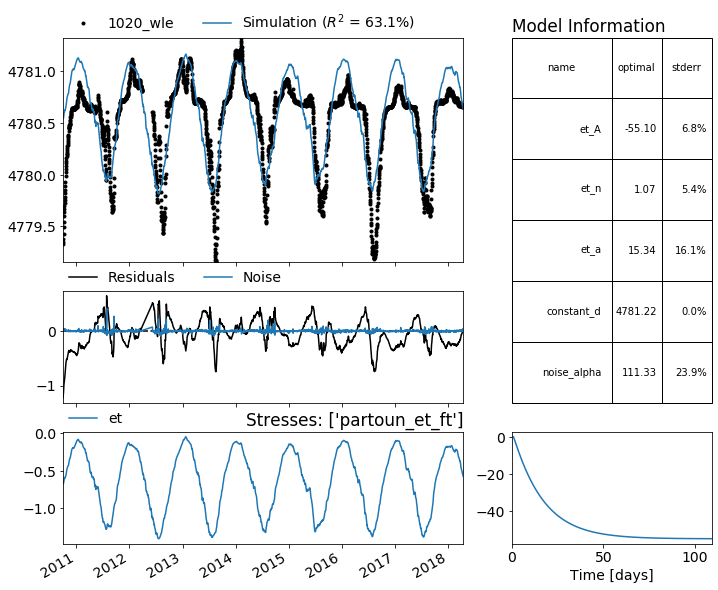

In [19]:
models = {}
for col in comb_data.columns:
    if "_wle" in col:
        ml = ps.Model(comb_data[col])
        et = ps.StressModel(comb_data['partoun_et_ft'], up=False, rfunc=ps.Gamma,  name="et", settings="evap")
        #pr = ps.StressModel(comb_data['partoun_ppt_ft'], ps.Gamma, name='prec')
        ml.add_stressmodel(et)
        #ml.add_stressmodel(pr)
        ml.solve()
        ml.plots.results()
        plt.savefig(file_place + f"PASTAS_et_{col}")
        #plt.close()
        evp = ml.stats.evp()
        models[col] = ml
        print(f"The explained variance percentage in {col} is: {evp}")



# ET PPT Model

INFO: Inferred frequency from time series SG25A_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25A_wle: freq=D 
INFO: Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and f

Model Results SG25A_wle               Fit Statistics
nfev     21                     EVP            77.57
nobs     3175                   R2              0.78
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            13.77
tmax     2019-08-07 00:00:00    BIC            62.27
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -201.245387  ±14.24%  -124.575444  True
et_n            0.494354   ±3.65%     1.000000  True
et_a         1962.929127  ±29.55%    10.000000  True
prec_A         12.868056   ±5.14%   132.124274  True
prec_n          1.981055   ±2.84%     1.000000  True
prec_a          1.442806   ±6.21%    10.000000  True
constant_d   4788.376698   ±0.01%  4786.107236  True
noise_alpha    36.886064  ±15.32%     1.000000  True

Parameter corr

INFO: Inferred frequency from time series SG25B_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25B_wle: freq=D 
INFO: Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25A_wle is: 77.57300728573905
Model Results SG25B_wle               Fit Statistics
nfev     32                     EVP            84.65
nobs     3131                   R2              0.84
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            16.25
tmax     2019-08-07 00:00:00    BIC            64.64
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -366.206187   ±9.99%  -124.575444  True
et_n            0.547921   ±2.82%     1.000000  True
et_a         4999.999996  ±24.18%    10.000000  True
prec_A         18.092157  ±12.71%   132.124274  True
prec_n          1.444173   ±2.91%     1.000000  True
prec_a          7.621591  ±13.08%    10.000000  True
constant_d   4789.744687   ±0.01%  4786.212407  True

INFO: Inferred frequency from time series SG25C_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25C_wle: freq=D 
INFO: Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25B_wle is: 84.65038543650559
Model Results SG25C_wle               Fit Statistics
nfev     34                     EVP            53.07
nobs     3131                   R2              0.51
noise    True                   RMSE            0.21
tmin     2010-10-01 00:00:00    AIC            16.42
tmax     2019-08-07 00:00:00    BIC            64.82
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -284.564687  ±23.02%  -124.575444  True
et_n            0.612653   ±3.62%     1.000000  True
et_a         3177.518794  ±39.90%    10.000000  True
prec_A         39.245272  ±42.50%   132.124274  True
prec_n          1.068856   ±3.42%     1.000000  True
prec_a         42.469968  ±45.57%    10.000000  True
constant_d   4791.980804   ±0.01%  4789.013644  True

INFO: Inferred frequency from time series SG25D_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25D_wle: freq=D 
INFO: Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25C_wle is: 53.07374632507636
Model Results SG25D_wle               Fit Statistics
nfev     28                     EVP            67.66
nobs     2856                   R2              0.67
noise    True                   RMSE            0.21
tmin     2010-10-01 00:00:00    AIC            16.47
tmax     2019-08-07 00:00:00    BIC            64.13
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -339.026753  ±19.29%  -124.575444  True
et_n            0.593531   ±2.36%     1.000000  True
et_a         2027.311713  ±33.10%    10.000000  True
prec_A         32.744622  ±12.65%   132.124274  True
prec_n          1.490884   ±2.66%     1.000000  True
prec_a         11.341659  ±12.31%    10.000000  True
constant_d   4792.152344   ±0.01%  4788.363947  True

INFO: Inferred frequency from time series 1011_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1011_wle: freq=D 
INFO: Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled 

The explained variance percentage in SG25D_wle is: 67.65505799682927
Model Results 1011_wle                 Fit Statistics
nfev     27                     EVP             34.21
nobs     3231                   R2               0.34
noise    True                   RMSE             0.36
tmin     2010-10-01 00:00:00    AIC             13.98
tmax     2019-08-07 00:00:00    BIC             62.62
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -45.588754   ±12.98%  -124.575444  True
et_n            0.845595    ±7.48%     1.000000  True
et_a           43.368278   ±29.37%    10.000000  True
prec_A         69.589430  ±252.13%   132.124274  True
prec_n          0.903866    ±8.19%     1.000000  True
prec_a        179.416282  ±290.14%    10.000000  True
constant_d   4782.674178    ±0.01%  

INFO: Inferred frequency from time series 1012_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1012_wle: freq=D 
INFO: Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1011_wle is: 34.20710922943921
Model Results 1012_wle                 Fit Statistics
nfev     36                     EVP              9.14
nobs     2880                   R2               0.09
noise    True                   RMSE             0.07
tmin     2010-10-01 00:00:00    AIC             19.75
tmax     2019-08-07 00:00:00    BIC             67.47
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -21.124366   ±73.23%  -124.575444  True
et_n            0.751291    ±8.89%     1.000000  True
et_a          258.788268  ±115.54%    10.000000  True
prec_A          6.187609  ±184.59%   132.124274  True
prec_n          0.551459   ±28.38%     1.000000  True
prec_a       1451.748976  ±305.17%    10.000000  True
constant_d   4783.197108    ±0.00%  4

INFO: Inferred frequency from time series 1013_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1013_wle: freq=D 
INFO: Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1012_wle is: 9.135626376910688
Model Results 1013_wle                Fit Statistics
nfev     25                     EVP             4.63
nobs     2481                   R2              0.04
noise    True                   RMSE            0.47
tmin     2010-10-25 00:00:00    AIC            13.66
tmax     2019-07-17 00:00:00    BIC            60.19
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -139.942008   ±4.80%  -124.575444  True
et_n            1.163175   ±5.02%     1.000000  True
et_a           29.345456  ±11.18%    10.000000  True
prec_A        231.246628  ±28.15%   132.124274  True
prec_n          1.209925   ±2.59%     1.000000  True
prec_a         57.896738  ±27.61%    10.000000  True
constant_d   4780.915469   ±0.00%  4779.996845  True


INFO: Inferred frequency from time series 1014_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1014_wle: freq=D 
INFO: Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1013_wle is: 4.6260209327573465
Model Results 1014_wle                Fit Statistics
nfev     23                     EVP            39.04
nobs     1842                   R2              0.34
noise    True                   RMSE            0.61
tmin     2012-12-01 00:00:00    AIC            12.87
tmax     2018-09-30 00:00:00    BIC            57.02
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -164.304403   ±6.46%  -124.575444  True
et_n            1.215642   ±7.06%     1.000000  True
et_a           26.468255  ±15.47%    10.000000  True
prec_A        230.917239  ±63.95%   132.124274  True
prec_n          1.173703   ±4.54%     1.000000  True
prec_a         61.879525  ±62.22%    10.000000  True
constant_d   4782.050386   ±0.01%  4780.877503  True

INFO: Inferred frequency from time series 1016_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1016_wle: freq=D 
INFO: Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fille

The explained variance percentage in 1014_wle is: 39.0374379140491
Model Results 1016_wle                Fit Statistics
nfev     25                     EVP            48.00
nobs     3158                   R2              0.48
noise    True                   RMSE            0.44
tmin     2010-10-01 00:00:00    AIC            11.55
tmax     2019-08-07 00:00:00    BIC            60.02
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -96.794397   ±9.37%  -124.575444  True
et_n            1.222035  ±10.75%     1.000000  True
et_a           29.078246  ±22.82%    10.000000  True
prec_A         82.834803  ±45.84%   132.124274  True
prec_n          1.288802   ±5.70%     1.000000  True
prec_a         28.289836  ±45.02%    10.000000  True
constant_d   4780.191010   ±0.00%  4779.218120  True
n

INFO: Inferred frequency from time series 1017_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1017_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1016_wle is: 48.00097042584598
Model Results 1017_wle                Fit Statistics
nfev     32                     EVP            75.00
nobs     1492                   R2              0.74
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            17.49
tmax     2014-10-31 00:00:00    BIC            59.95
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -36.463381   ±7.70%  -124.575444  True
et_n            1.111661   ±9.60%     1.000000  True
et_a           25.279227  ±22.02%    10.000000  True
prec_A          4.505944  ±11.28%   132.124274  True
prec_n          1.718419   ±5.84%     1.000000  True
prec_a          1.612968  ±14.41%    10.000000  True
constant_d   4779.165657   ±0.00%  4778.714660  True


INFO: Inferred frequency from time series 1019_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1019_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1017_wle is: 74.99999948245521
Model Results 1019_wle                Fit Statistics
nfev     27                     EVP            76.94
nobs     3233                   R2              0.77
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            16.81
tmax     2019-08-07 00:00:00    BIC            65.46
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -39.059943   ±5.49%  -124.575444  True
et_n            1.261023   ±7.28%     1.000000  True
et_a           27.186098  ±14.31%    10.000000  True
prec_A         21.909458  ±23.91%   132.124274  True
prec_n          1.246057   ±3.36%     1.000000  True
prec_a         17.663848  ±24.78%    10.000000  True
constant_d   4780.201679   ±0.00%  4779.764937  True


INFO: Inferred frequency from time series 1020_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1020_wle: freq=D 
INFO: Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fille

The explained variance percentage in 1019_wle is: 76.94262648070308
Model Results 1020_wle                Fit Statistics
nfev     40                     EVP            66.53
nobs     2687                   R2              0.65
noise    True                   RMSE            0.24
tmin     2010-10-01 00:00:00    AIC            15.18
tmax     2018-04-17 00:00:00    BIC            62.35
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -55.741199   ±6.30%  -124.575444  True
et_n            1.227841   ±6.78%     1.000000  True
et_a           17.134734  ±16.64%    10.000000  True
prec_A          9.871533  ±11.23%   132.124274  True
prec_n          1.719147   ±4.21%     1.000000  True
prec_a          2.781983  ±12.20%    10.000000  True
constant_d   4781.204957   ±0.00%  4780.529677  True


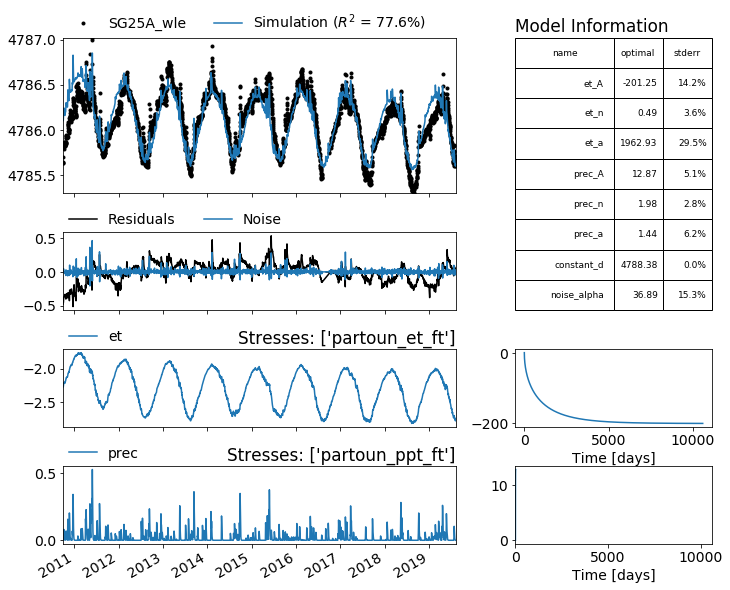

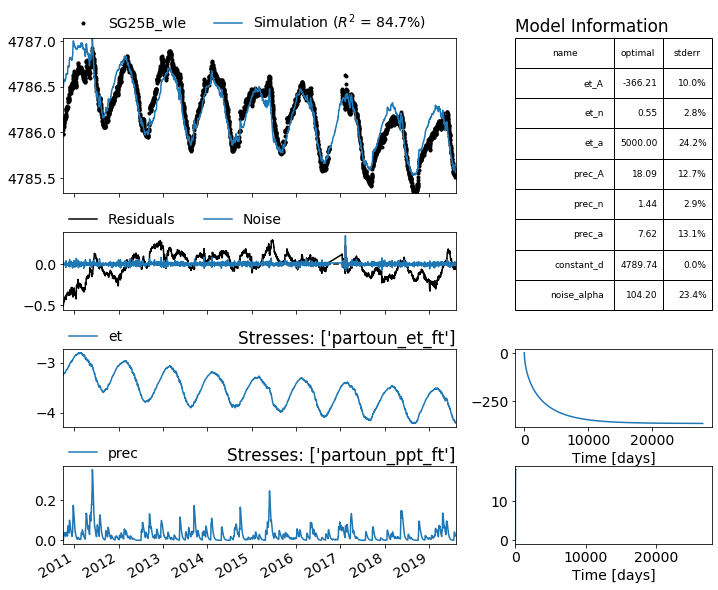

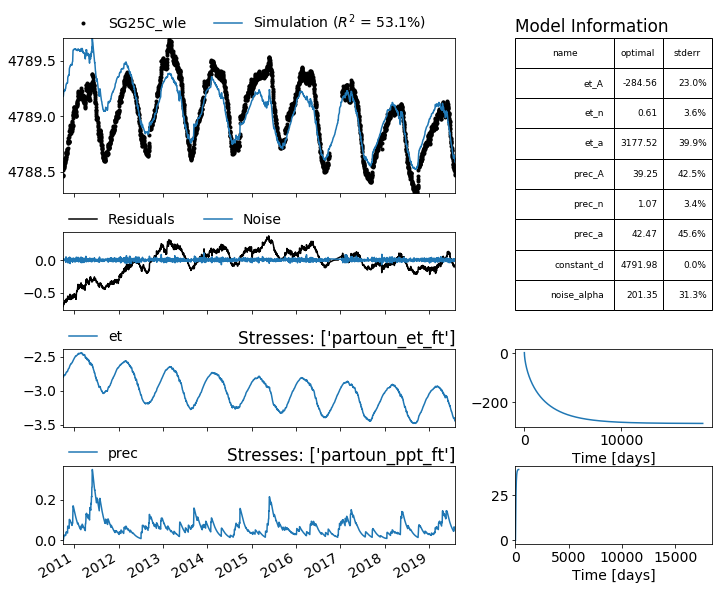

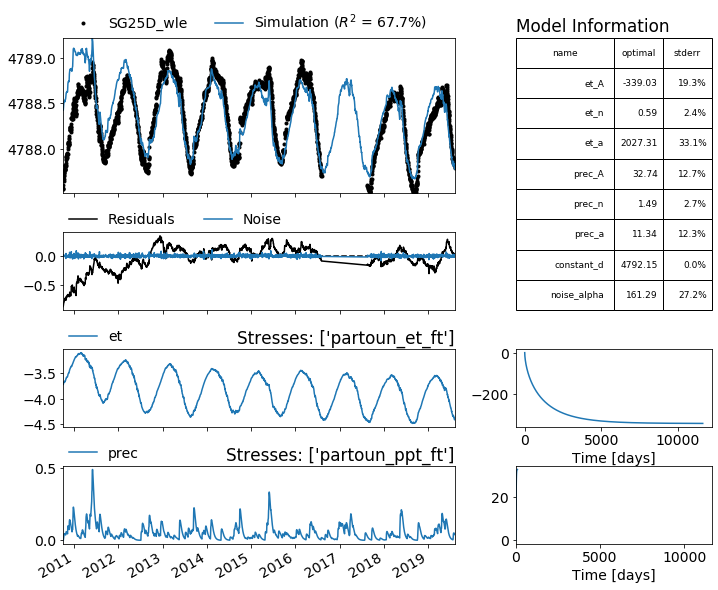

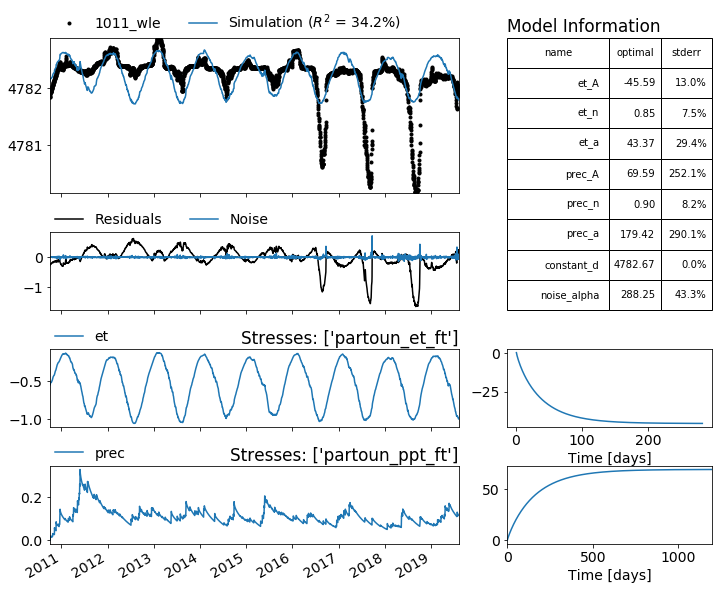

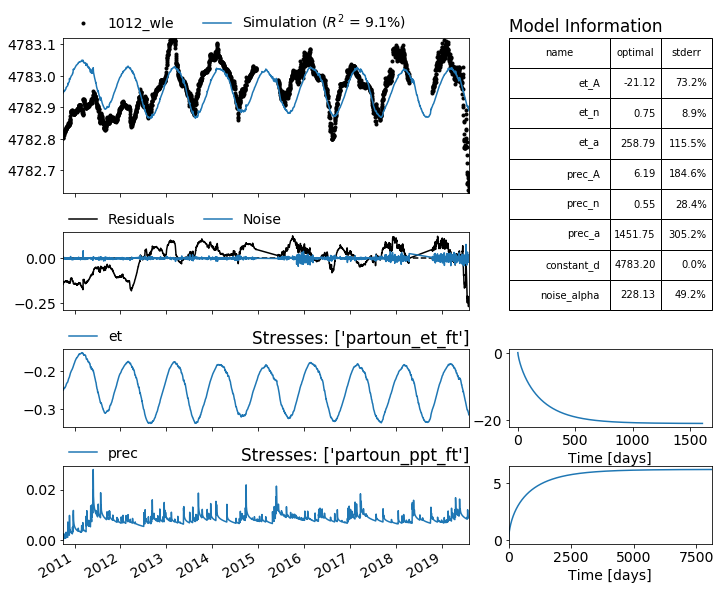

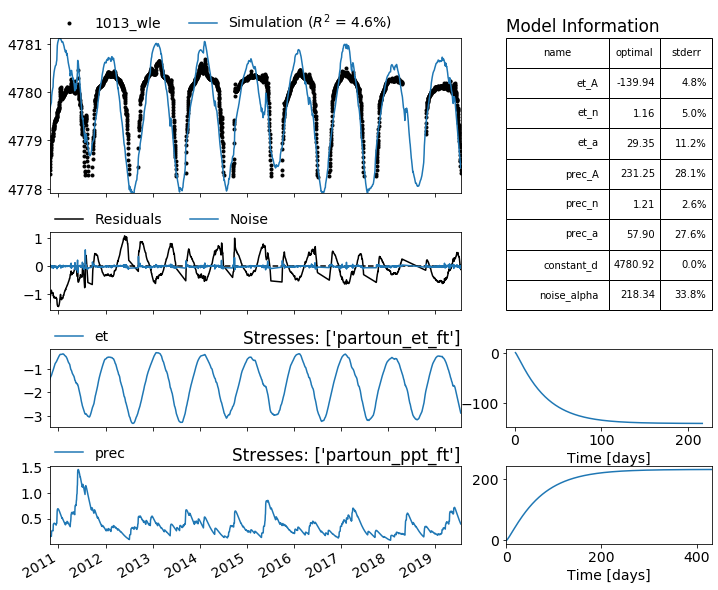

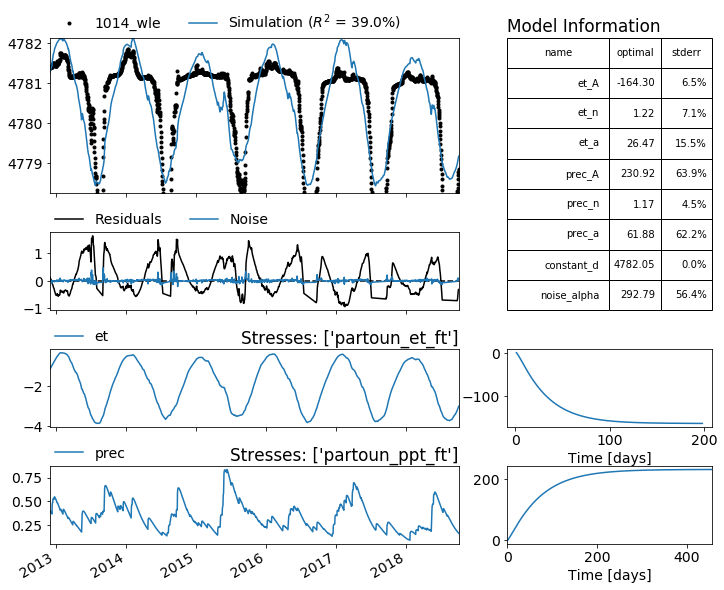

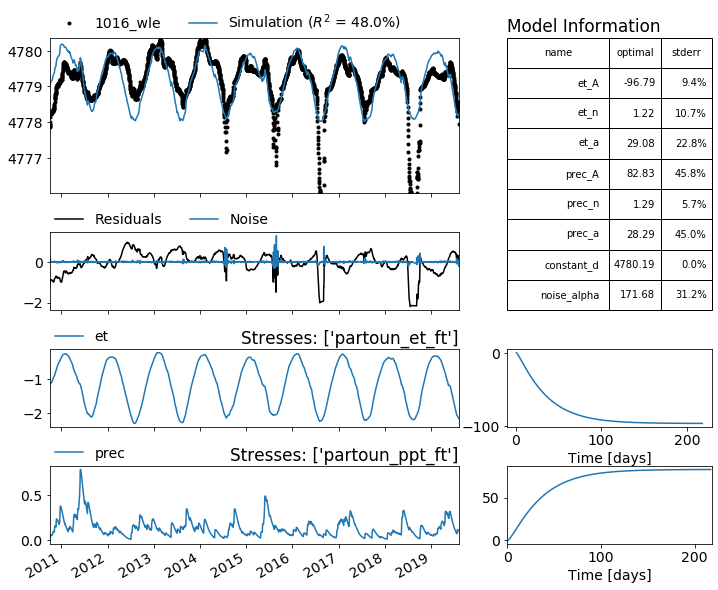

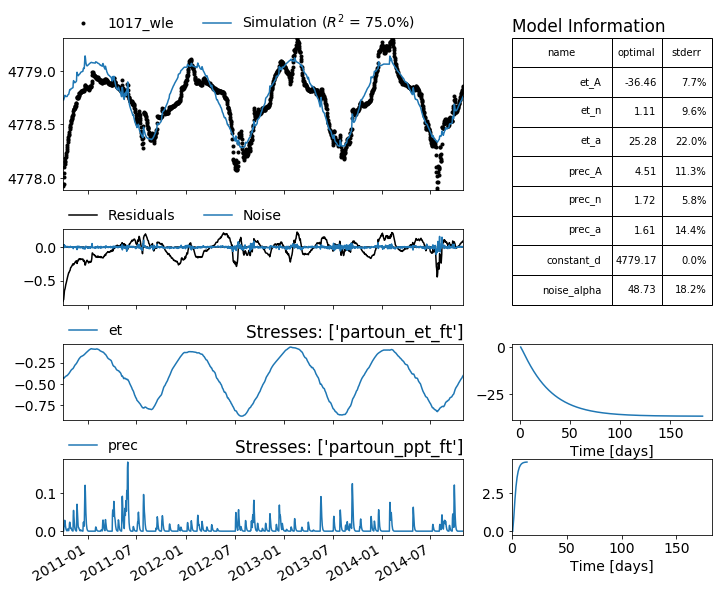

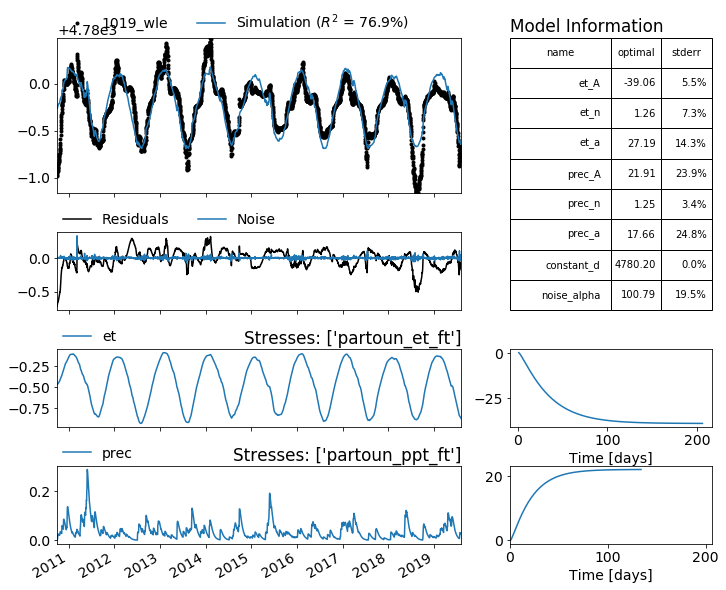

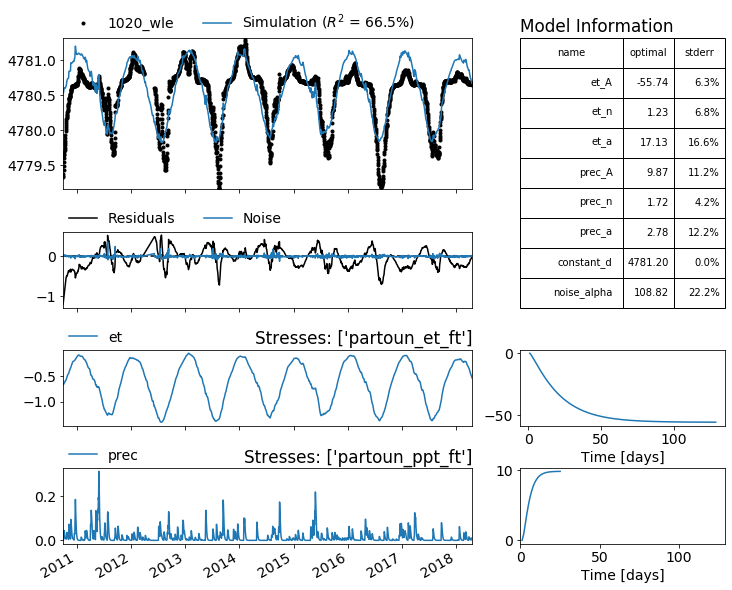

In [20]:
models = {}
for col in comb_data.columns:
    if "_wle" in col:
        ml = ps.Model(comb_data[col])
        et = ps.StressModel(comb_data['partoun_et_ft'], up=False, rfunc=ps.Gamma,  name="et", settings="evap")
        pr = ps.StressModel(comb_data['partoun_ppt_ft'], rfunc=ps.Gamma, name='prec')
        ml.add_stressmodel(et)
        ml.add_stressmodel(pr)
        ml.solve()
        ml.plots.results()
        plt.savefig(file_place + f"PASTAS_et_ppt_{col}")
        evp = ml.stats.evp()
        models[col] = ml
        print(f"The explained variance percentage in {col} is: {evp}")



INFO: Inferred frequency from time series SG25A_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25A_wle: freq=D 
INFO: Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25A_wle: 58 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and f

Model Results SG25A_wle               Fit Statistics
nfev     35                     EVP            77.20
nobs     3175                   R2              0.77
noise    True                   RMSE            0.14
tmin     2010-10-01 00:00:00    AIC            13.58
tmax     2019-08-07 00:00:00    BIC            62.09
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -46.077286  ±14.81%  -124.575444  True
et_rho          1.030184  ±47.83%     1.000000  True
et_cS          81.177869  ±55.73%   100.000000  True
prec_A         15.555934   ±4.86%   132.124274  True
prec_n          1.911876   ±2.55%     1.000000  True
prec_a          1.588214   ±5.83%    10.000000  True
constant_d   4786.612057   ±0.00%  4786.107236  True
noise_alpha    35.027785  ±14.76%     1.000000  True

Parameter corr

INFO: Inferred frequency from time series SG25B_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25B_wle: freq=D 
INFO: Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25B_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25A_wle is: 77.19506055794788
Model Results SG25B_wle               Fit Statistics
nfev     50                     EVP            52.10
nobs     3131                   R2              0.52
noise    True                   RMSE            0.25
tmin     2010-10-01 00:00:00    AIC            15.95
tmax     2019-08-07 00:00:00    BIC            64.35
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -45.449206  ±13.74%  -124.575444  True
et_rho          1.242884  ±36.54%     1.000000  True
et_cS          74.541833  ±44.80%   100.000000  True
prec_A         18.338733  ±10.27%   132.124274  True
prec_n          1.476756   ±2.61%     1.000000  True
prec_a          5.940837  ±11.02%    10.000000  True
constant_d   4786.690731   ±0.00%  4786.212407  True

INFO: Inferred frequency from time series SG25C_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25C_wle: freq=D 
INFO: Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25C_wle: 102 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25B_wle is: 52.10029793478086
Model Results SG25C_wle                Fit Statistics
nfev     42                     EVP             62.84
nobs     3131                   R2               0.63
noise    True                   RMSE             0.18
tmin     2010-10-01 00:00:00    AIC             16.37
tmax     2019-08-07 00:00:00    BIC             64.76
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -85.182923   ±62.98%  -124.575444  True
et_rho          0.371813  ±121.87%     1.000000  True
et_cS         585.830703  ±220.53%   100.000000  True
prec_A         37.083837   ±28.83%   132.124274  True
prec_n          1.110809    ±2.82%     1.000000  True
prec_a         29.069920   ±30.56%    10.000000  True
constant_d   4789.956413    ±0.01%  

INFO: Inferred frequency from time series SG25D_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series SG25D_wle: freq=D 
INFO: Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series SG25D_wle: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and

The explained variance percentage in SG25C_wle is: 62.8428750904427
Model Results SG25D_wle               Fit Statistics
nfev     33                     EVP            76.23
nobs     2856                   R2              0.76
noise    True                   RMSE            0.18
tmin     2010-10-01 00:00:00    AIC            16.16
tmax     2019-08-07 00:00:00    BIC            63.82
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A          -60.403130  ±10.75%  -124.575444  True
et_rho          1.388480  ±30.45%     1.000000  True
et_cS          71.098517  ±35.62%   100.000000  True
prec_A         30.589250  ±10.64%   132.124274  True
prec_n          1.495796   ±2.34%     1.000000  True
prec_a          8.549162  ±10.69%    10.000000  True
constant_d   4789.023254   ±0.00%  4788.363947  True


INFO: Inferred frequency from time series 1011_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1011_wle: freq=D 
INFO: Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1011_wle: 2 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled 

The explained variance percentage in SG25D_wle is: 76.23131948154467
Model Results 1011_wle                  Fit Statistics
nfev     27                     EVP              31.37
nobs     3231                   R2                0.31
noise    True                   RMSE              0.36
tmin     2010-10-01 00:00:00    AIC              13.97
tmax     2019-08-07 00:00:00    BIC              62.61
freq     D                      ___                   
warmup   3650 days 00:00:00     ___                   
solver   LeastSquares           ___                   

Parameters (8 were optimized)
                 optimal     stderr      initial  vary
et_A          -49.564936   ±169.18%  -124.575444  True
et_rho          0.037007   ±587.92%     1.000000  True
et_cS        2669.998867  ±1173.91%   100.000000  True
prec_A         31.706005   ±260.23%   132.124274  True
prec_n          0.840276    ±10.49%     1.000000  True
prec_a        108.589209   ±327.51%    10.000000  True
constant_d   4782.76

INFO: Inferred frequency from time series 1012_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1012_wle: freq=D 
INFO: Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1012_wle: 353 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1011_wle is: 31.37490787722634
Model Results 1012_wle                 Fit Statistics
nfev     41                     EVP             29.73
nobs     2880                   R2               0.30
noise    True                   RMSE             0.06
tmin     2010-10-01 00:00:00    AIC             19.77
tmax     2019-08-07 00:00:00    BIC             67.49
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -13.428803   ±64.18%  -124.575444  True
et_rho          0.038866  ±216.78%     1.000000  True
et_cS        3475.858488  ±432.53%   100.000000  True
prec_A          5.012016  ±194.78%   132.124274  True
prec_n          0.469366   ±34.70%     1.000000  True
prec_a       3056.760054  ±368.06%    10.000000  True
constant_d   4783.108349    ±0.00%  4

INFO: Inferred frequency from time series 1013_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1013_wle: freq=D 
INFO: Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1013_wle: 707 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1012_wle is: 29.729142897635874
Model Results 1013_wle                Fit Statistics
nfev     44                     EVP            13.25
nobs     2481                   R2              0.13
noise    True                   RMSE            0.44
tmin     2010-10-25 00:00:00    AIC            13.67
tmax     2019-07-17 00:00:00    BIC            60.20
freq     D                      ___                 
warmup   3650 days 00:00:00     ___                 
solver   LeastSquares           ___                 

Parameters (8 were optimized)
                 optimal   stderr      initial  vary
et_A         -120.563893   ±4.22%  -124.575444  True
et_rho          6.422062   ±7.65%     1.000000  True
et_cS           9.162544   ±7.83%   100.000000  True
prec_A        154.406997  ±18.93%   132.124274  True
prec_n          1.279123   ±2.34%     1.000000  True
prec_a         30.215494  ±18.47%    10.000000  True
constant_d   4780.801730   ±0.00%  4779.996845  True

INFO: Inferred frequency from time series 1014_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1014_wle: freq=D 
INFO: Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1014_wle: 288 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fil

The explained variance percentage in 1013_wle is: 13.25427449489246
Model Results 1014_wle                 Fit Statistics
nfev     48                     EVP             59.90
nobs     1842                   R2               0.48
noise    True                   RMSE             0.54
tmin     2012-12-01 00:00:00    AIC             12.82
tmax     2018-09-30 00:00:00    BIC             56.97
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A         -294.287614  ±112.83%  -124.575444  True
et_rho          0.064245  ±339.19%     1.000000  True
et_cS        3007.860826  ±675.01%   100.000000  True
prec_A        195.530468   ±80.39%   132.124274  True
prec_n          1.111048    ±5.07%     1.000000  True
prec_a         66.293270   ±81.16%    10.000000  True
constant_d   4783.543224    ±0.07%  4

INFO: Inferred frequency from time series 1016_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1016_wle: freq=D 
INFO: Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1016_wle: 75 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fille

The explained variance percentage in 1014_wle is: 59.89685777399839
Model Results 1016_wle                 Fit Statistics
nfev     50                     EVP             52.99
nobs     3158                   R2               0.53
noise    True                   RMSE             0.42
tmin     2010-10-01 00:00:00    AIC             11.56
tmax     2019-08-07 00:00:00    BIC             60.02
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A         -176.783644  ±104.26%  -124.575444  True
et_rho          0.058367  ±322.57%     1.000000  True
et_cS        3266.641815  ±642.31%   100.000000  True
prec_A         78.755085   ±57.93%   132.124274  True
prec_n          1.222694    ±6.29%     1.000000  True
prec_a         33.482023   ±58.27%    10.000000  True
constant_d   4781.096564    ±0.04%  4

INFO: Inferred frequency from time series 1017_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1017_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1016_wle is: 52.98723474772813
Model Results 1017_wle                 Fit Statistics
nfev     41                     EVP             75.04
nobs     1492                   R2               0.74
noise    True                   RMSE             0.14
tmin     2010-10-01 00:00:00    AIC             17.48
tmax     2014-10-31 00:00:00    BIC             59.95
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -54.816166   ±69.18%  -124.575444  True
et_rho          0.091295  ±190.03%     1.000000  True
et_cS         931.919796  ±375.11%   100.000000  True
prec_A          3.681198   ±10.80%   132.124274  True
prec_n          1.843282    ±6.64%     1.000000  True
prec_a          1.236199   ±14.55%    10.000000  True
constant_d   4779.377357    ±0.01%  4

INFO: Inferred frequency from time series 1019_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1019_wle: freq=D 
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate


The explained variance percentage in 1017_wle is: 75.0354858959133
Model Results 1019_wle                 Fit Statistics
nfev     41                     EVP             76.42
nobs     3233                   R2               0.76
noise    True                   RMSE             0.14
tmin     2010-10-01 00:00:00    AIC             16.79
tmax     2019-08-07 00:00:00    BIC             65.43
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A          -92.415622   ±36.42%  -124.575444  True
et_rho          0.039784  ±124.41%     1.000000  True
et_cS        9326.644124  ±247.76%   100.000000  True
prec_A         19.790846   ±26.53%   132.124274  True
prec_n          1.200850    ±3.61%     1.000000  True
prec_a         17.960483   ±28.16%    10.000000  True
constant_d   4780.747535    ±0.00%  47

INFO: Inferred frequency from time series 1020_wle: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series 1020_wle: freq=D 
INFO: Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series 1020_wle: 69 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series partoun_et_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_et_ft: freq=D 
INFO: Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_et_ft: 71 nan-value(s) was/were found and filled with: interpolate
INFO: Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series partoun_ppt_ft: freq=D 
INFO: Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and filled with: interpolate
INFO:pastas.timeseries:Time Series partoun_ppt_ft: 20 nan-value(s) was/were found and fille

The explained variance percentage in 1019_wle is: 76.41727003913861
Model Results 1020_wle                 Fit Statistics
nfev     62                     EVP             67.35
nobs     2687                   R2               0.66
noise    True                   RMSE             0.24
tmin     2010-10-01 00:00:00    AIC             15.18
tmax     2018-04-17 00:00:00    BIC             62.35
freq     D                      ___                  
warmup   3650 days 00:00:00     ___                  
solver   LeastSquares           ___                  

Parameters (8 were optimized)
                 optimal    stderr      initial  vary
et_A         -126.149550   ±56.92%  -124.575444  True
et_rho          0.027985  ±212.67%     1.000000  True
et_cS        9999.992321  ±424.53%   100.000000  True
prec_A          6.382340   ±10.79%   132.124274  True
prec_n          1.877052    ±5.12%     1.000000  True
prec_a          1.800350   ±12.34%    10.000000  True
constant_d   4781.917122    ±0.01%  4

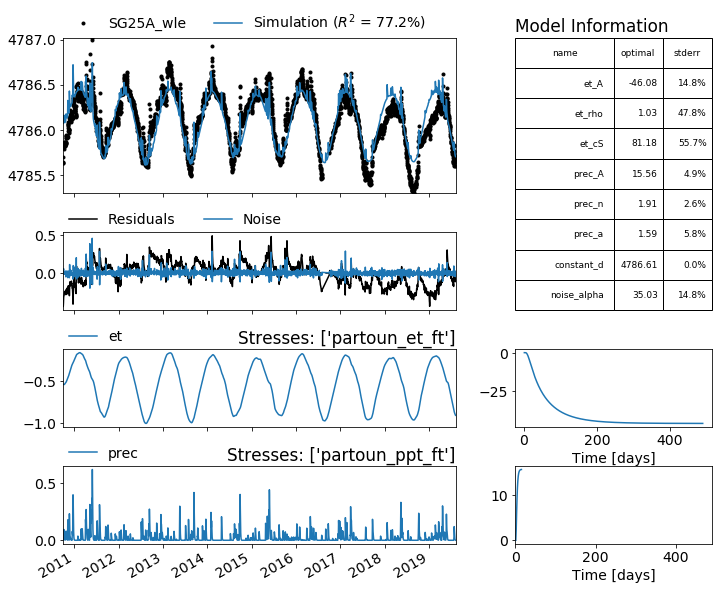

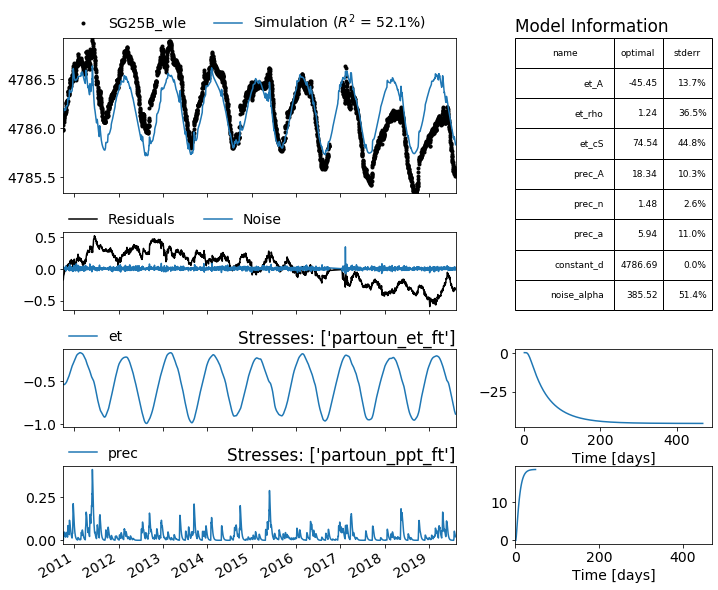

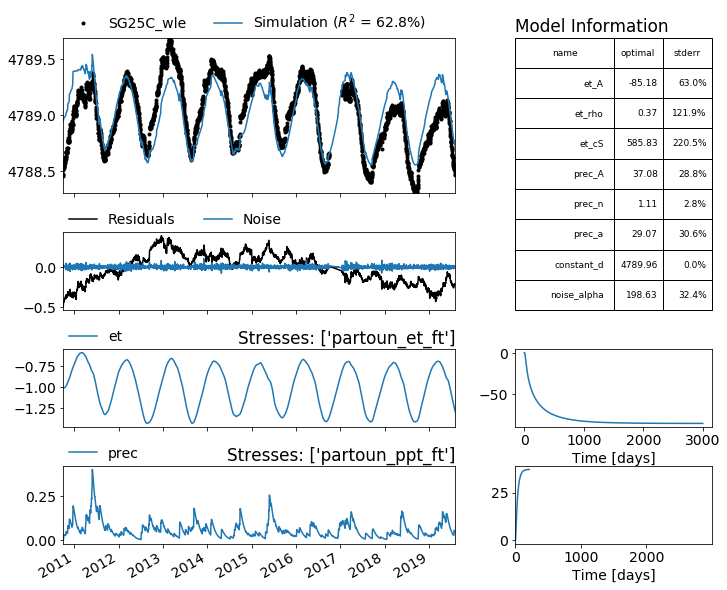

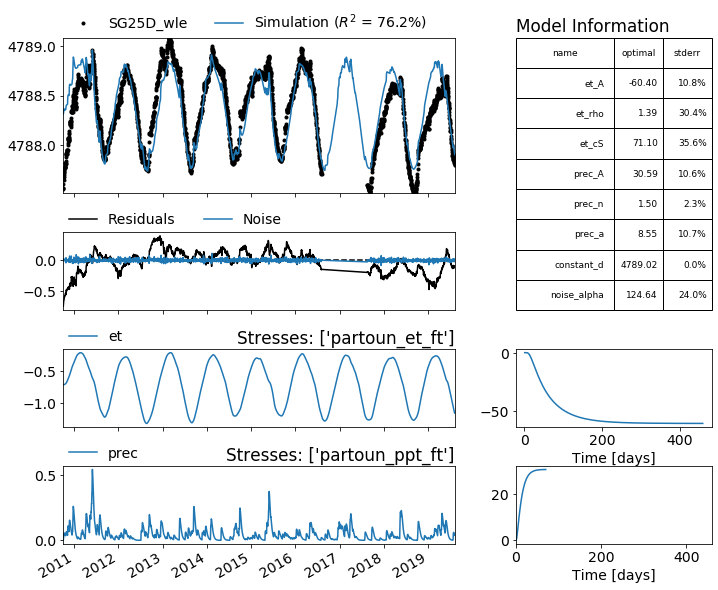

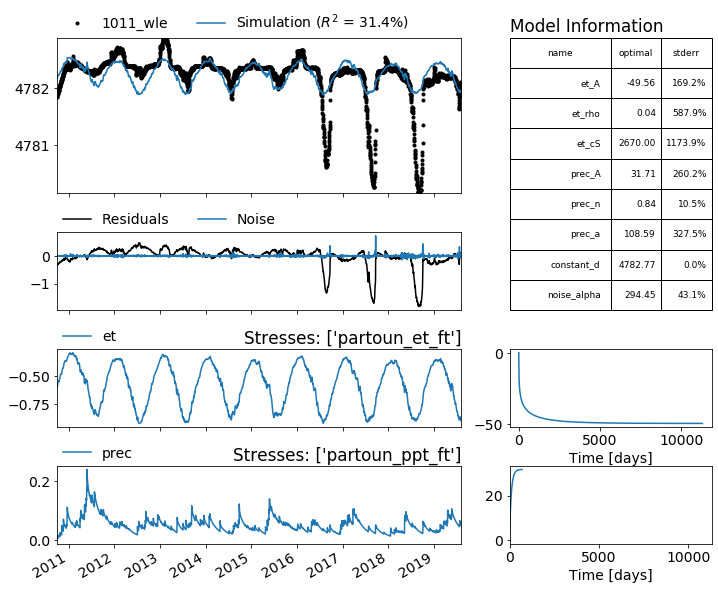

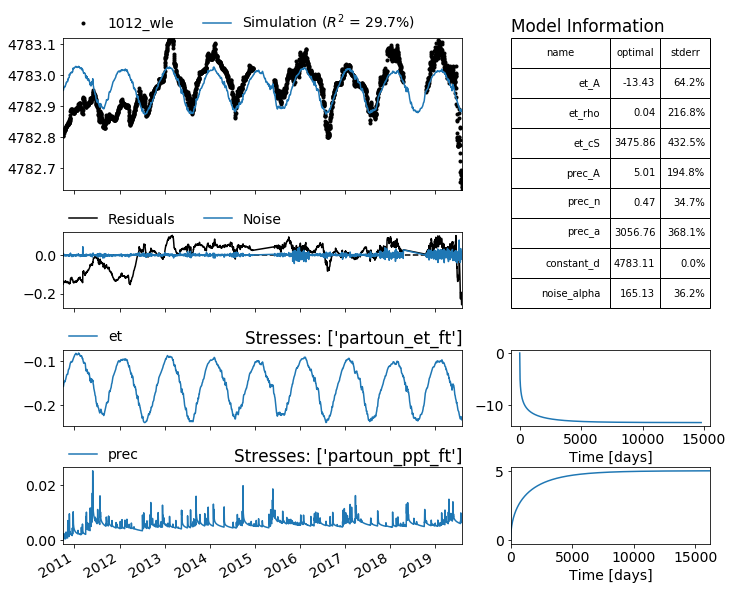

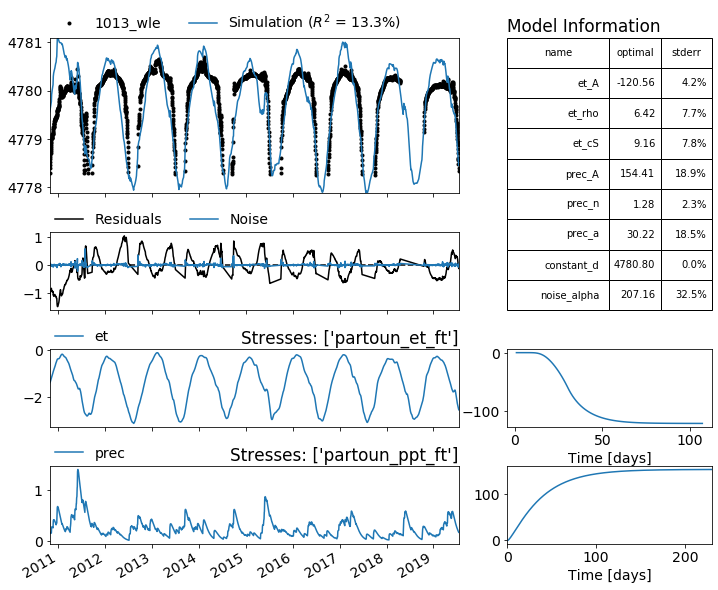

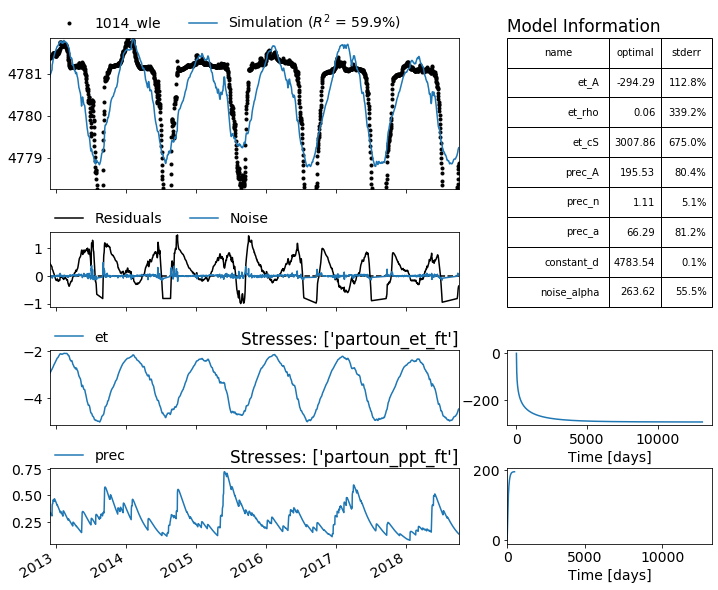

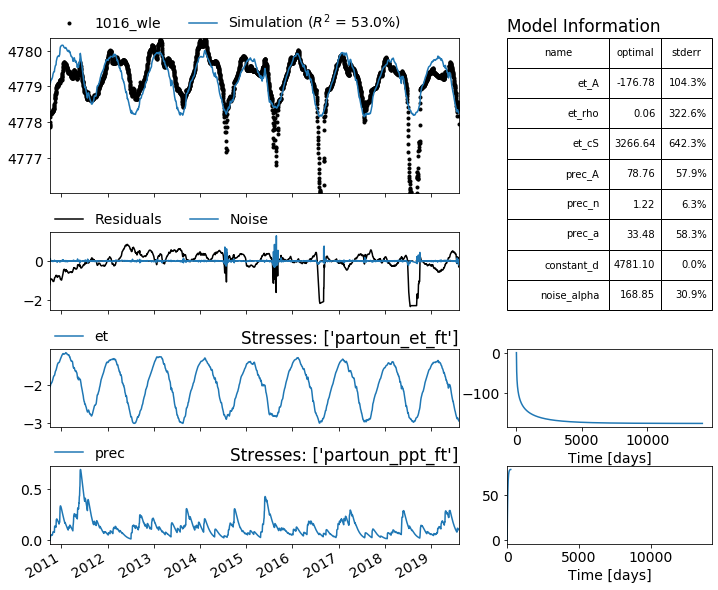

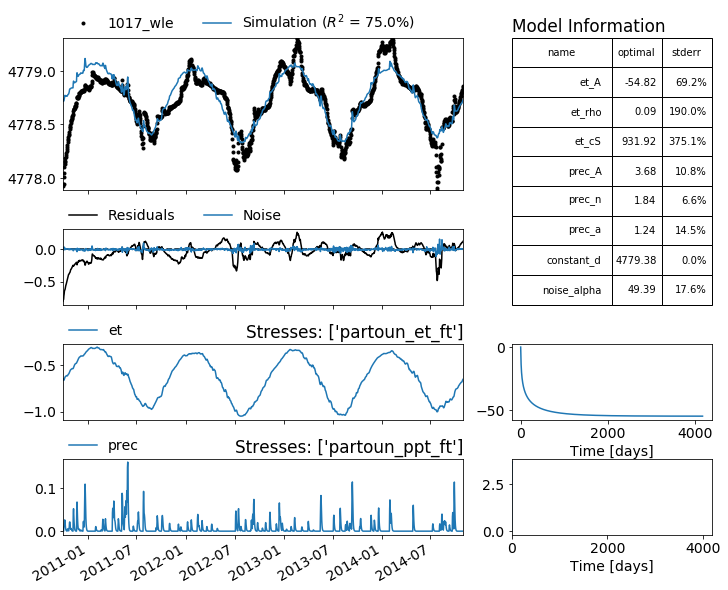

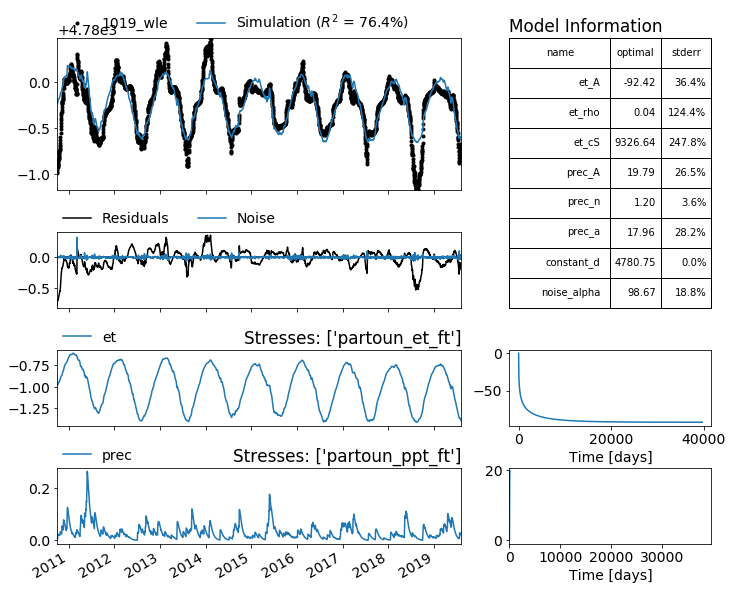

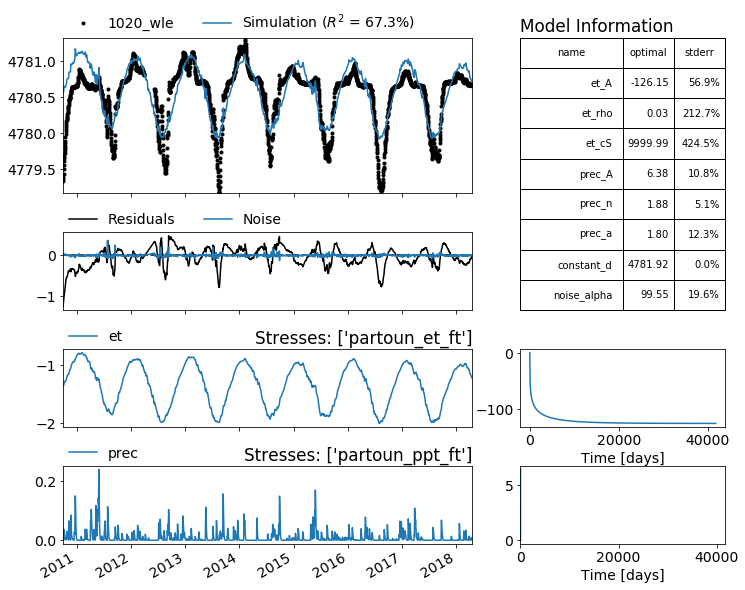

In [28]:
models = {}
for col in comb_data.columns:
    if "_wle" in col:
        ml = ps.Model(comb_data[col])
        et = ps.StressModel(comb_data['partoun_et_ft'], up=False, rfunc=ps.Hantush,  name="et", settings="evap")
        pr = ps.StressModel(comb_data['partoun_ppt_ft'], rfunc=ps.Gamma, name='prec')
        ml.add_stressmodel(et)
        ml.add_stressmodel(pr)
        ml.solve()
        ml.plots.results()
        plt.savefig(file_place + f"PASTAS_et_ppt_{col}")
        evp = ml.stats.evp()
        models[col] = ml
        print(f"The explained variance percentage in {col} is: {evp}")

INFO: Inferred frequency from time series Residuals: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series Residuals: freq=D 
INFO: Time Series Residuals: 377 nan-value(s) was/were found and filled with: drop
INFO:pastas.timeseries:Time Series Residuals: 377 nan-value(s) was/were found and filled with: drop
INFO: Inferred frequency from time series Wheeler_swe_ft: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series Wheeler_swe_ft: freq=D 


Model Results Residuals              Fit Statistics
nfev     30                     EVP           43.36
nobs     2856                   R2             0.42
noise    True                   RMSE           0.19
tmin     2010-10-01 00:00:00    AIC           10.19
tmax     2019-08-07 00:00:00    BIC           39.98
freq     D                      ___                
warmup   3650 days 00:00:00     ___                
solver   LeastSquares           ___                

Parameters (5 were optimized)
                 optimal    stderr    initial  vary
prec_A         69.225090  ±540.60%   1.766304  True
prec_n          2.012223   ±40.95%   1.000000  True
prec_a       5000.000000  ±346.00%  10.000000  True
constant_d     -0.142510  ±131.38%  -0.040069  True
noise_alpha   130.345305   ±28.56%   1.000000  True

Parameter correlations |rho| > 0.5
prec_A     prec_n       (-0.92, 0.99, -0.93, -0.96, 0.76, -0.89, 0.54)
           prec_a       (-0.92, 0.99, -0.93, -0.96, 0.76, -0.89, 0.54)
           

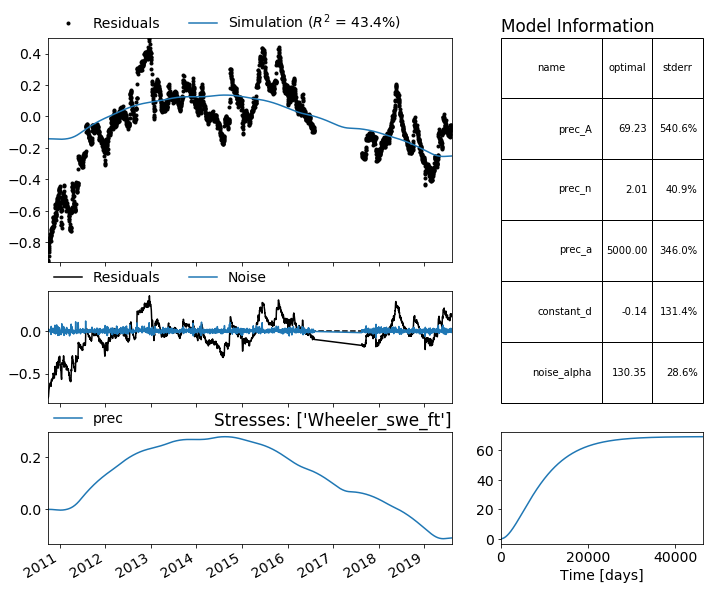

In [107]:

#wl = ps.StressModel(y1, up=False, rfunc=ps.Gamma,  name="trout")
#wl.update_stress(norm="mean")
#ml.add_stressmodel(wl)

#w = ps.StressModel(comb_data['trout'], rfunc=ps.Gamma,  name="waterlevel", settings="waterlevel")
# Normalize the stress by the mean such that only the variation in the waterlevel matters
#w.update_stress(norm="mean")
#ml.add_stressmodel(w)



#plt.plot(x,y)
#plt.twinx()
#plt.plot(x,y1,color='red')

In [65]:
w = ps.StressModel(comb_data['trout'], rfunc=ps.Exponential,  name="waterlevel", settings="waterlevel")

# Normalize the stress by the mean such that only the variation in the waterlevel matters
w.update_stress(norm="mean")

ml.add_stressmodel(w)
ml.solve()

INFO: Inferred frequency from time series trout: freq=D 
INFO:pastas.timeseries:Inferred frequency from time series trout: freq=D 


Model Results SG25A_wle                    Fit Statistics
nfev     41                     EVP                 22.31
nobs     3175                   R2                   0.22
noise    True                   RMSE                 0.26
tmin     2010-10-01 00:00:00    AIC                 12.85
tmax     2019-08-07 00:00:00    BIC                 61.36
freq     D                      ___                      
warmup   100 days 00:00:00      ___                      
solver   LeastSquares           ___                      

Parameters (8 were optimized)
                  optimal       stderr      initial  vary
recharge_A       0.433930       ±6.56%     1.760547  True
recharge_n       0.123908  ±181445.91%     1.000000  True
recharge_a       0.107289   ±70989.59%    10.000000  True
recharge_f      -2.000000      ±42.13%    -1.000000  True
waterlevel_A     0.895590     ±424.97%     0.113158  True
waterlevel_a  4984.799557     ±433.05%    10.000000  True
constant_d    4785.936035       ±0.00%  4

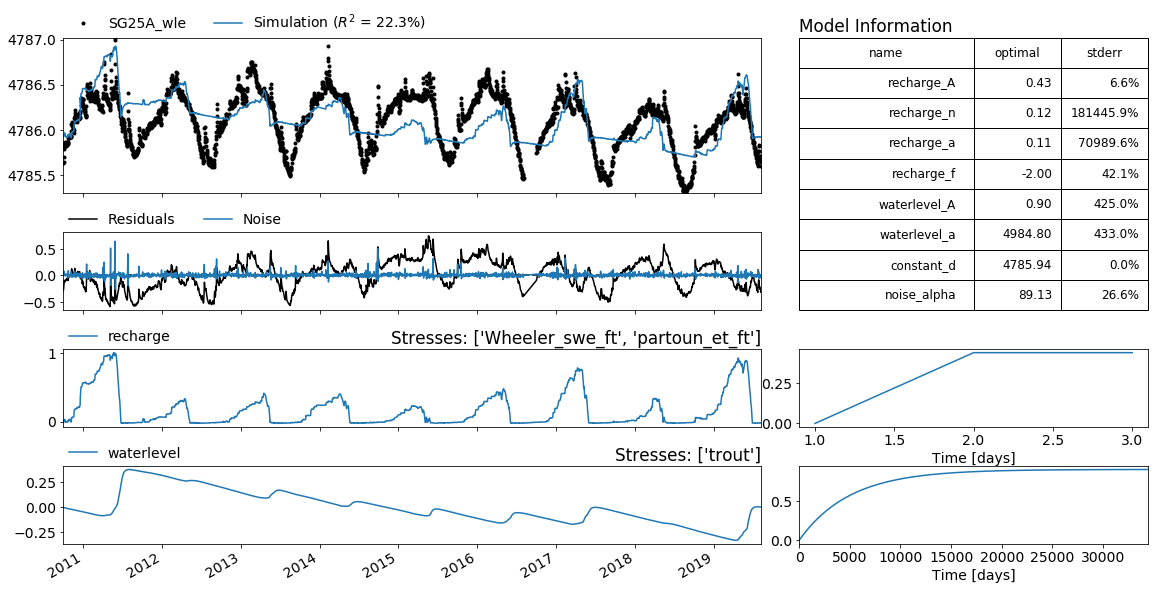

In [66]:
ml.plots.results(figsize=(16, 8))

In [ ]:
station = 'USC00426708'
dfs = {}
for station in st_df.index.get_level_values(0).unique()[3:]:
    stname = st_mt_df.loc[station,'Station Name'].split(" ")[0].lower()

    dfs[station] = st_df.loc[station].dropna(axis=1,how='all').rename(columns={'Precipitation':f'{stname}_ppt',
                                                            'Snow Depth':f'{stname}_snowdpt',
                                                           'Snow Fall':f'{stname}_snowfall',
                                                           'Min Temperature':f'{stname}_mintemp',
                                                           'Max Temperature':f'{stname}_maxtemp',
                                                           'Ref Evapotranspiration':f'{stname}_et'})
    if 'Multi-Day Precipitation' in dfs[station].columns:
        dfs[station] = dfs[station].drop(['Multi-Day Precipitation'],axis=1)

In [ ]:
weatherdata = pd.concat(dfs, axis=1)#
weatherdata.columns = weatherdata.columns.droplevel(0)
for col in weatherdata.columns:
    if 'goshute' in col or 'silver' in col or 'baker' in col or 'wheeler' in col or 'ibapah' in col or 'great' in col:
        weatherdata = weatherdata.drop(col, axis=1)

In [ ]:
weatherdata.index = pd.to_datetime(weatherdata.index)

In [ ]:
for col in weatherdata.columns:
    if '_ppt' in col and 'silver' not in col and 'baker' not in col and 'wheeler' not in col:
        df = weatherdata.groupby(pd.Grouper(freq='6M')).sum()
        df = df.replace(0.0, np.nan)
        plt.plot(df.index[1:-1],df[col][1:-1], label=col)
plt.grid()
plt.legend()

In [ ]:
sntl = pd.read_pickle(file_place+'snotel_data.pickle')
for col in sntl.columns:
    if 'Salinity' in col or 'Battery' in col or 'Air Temperature' in col:
        sntl = sntl.drop(col,axis=1)

for col in sntl.columns:
    if 'Precipitation Accumulation' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptaccm_mm'})
    elif 'Precipitation Increment - Snow-adj' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_pptincr_mm'})
    elif 'Soil Moisture' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soilmoist_pct'})
    elif 'Soil Temperature' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+col.split(" ")[6]+'_soiltemp_C'})
    elif 'Snow Depth' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_snowdepth_cm'})
    elif 'Snow Water' in col:
        sntl = sntl.rename(columns={col:col.split(" ")[0]+'_swe_mm'})
    else:
        sntl = sntl.drop(col,axis=1)
sntl.index = pd.to_datetime(sntl.index)

In [ ]:
climate_data = pd.concat([weatherdata.sort_index(),sntl.sort_index()],axis=1,sort=True)

In [ ]:
climate_data.columns

In [ ]:
climate_data['partoun_maxtemp'].plot()

In [ ]:
def climate_plotter(df, keyword, frq='6M',totaler='mean'):
    fig, ax = plt.subplots(1,1)
    for col in df.columns:
        if keyword in col:
            if totaler=='mean':
                df = df.groupby(pd.Grouper(freq=frq)).mean()
            elif totaler=='sum':
                df = df.groupby(pd.Grouper(freq=frq)).sum()
            else:
                df = df.groupby(pd.Grouper(freq=frq)).median()
            df = df.replace(0.0, np.nan)
            plt.plot(df.index,df[col], label=col)
    plt.grid()
    plt.legend()
    return fig, ax

In [ ]:
climate_plotter(climate_data,'maxtemp','1Y')

In [ ]:

st_mt_df

In [ ]:
st_df.loc['USC00421144'].columns

In [ ]:
rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

y_reg = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2016-01-01':]
x_reg= st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2016-01-01':].index
y_ugs = ugs_clim_raw_dly['et_ref']#*0.3048
x_ugs = ugs_clim_raw_dly.index
plt.plot(x_reg,y_reg)
plt.plot(x_ugs,y_ugs)

In [ ]:
wls = wls.set_index(['locationid','readingdate'])

In [ ]:
len(y_reg_clim.loc['2010-03-29':'2019-09-27'])

In [ ]:
x_1011 = wls.loc[1011,'waterelevation'].groupby(pd.Grouper(freq='1M')).mean().index
y_1011 = wls.loc[1011,'waterelevation'].groupby(pd.Grouper(freq='1M')).mean()
x_callpptmo = st_df.loc['USC00421144','Precipitation'].groupby(pd.Grouper(freq='1M')).mean().index
y_callpptmo = st_df.loc['USC00421144','Precipitation'].groupby(pd.Grouper(freq='1M')).mean()
plt.plot(x_1011,y_1011,color='blue')
plt.grid()
plt.twinx()
plt.plot(x_callpptmo,y_callpptmo,color='red')
plt.xlim('2008-01-01','2020-01-01')


In [ ]:
st_df

In [ ]:
x_1011 = wls.loc[1011,'waterelevation'].index
y_1011 = wls.loc[1011,'waterelevation']
plt.plot(x_1011,y_1011,zorder=1,color='blue')
plt.grid()
plt.twinx()
x_reg_clim = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2010-01-01':].index
y_reg_clim = st_df.loc['USC00421144','Ref Evapotranspiration'].loc['2010-01-01':]
plt.plot(x_reg_clim,y_reg_clim,color='orange',zorder=10)


In [ ]:
plt.scatter(y_reg_clim.loc['2010-03-29':'2019-09-27'],y_1011.resample('1D').median().loc['2010-03-29':'2019-09-27'])

In [ ]:
from scipy import signal


In [ ]:
et1011 =pd.concat([y_reg_clim.loc['2010-03-29':'2019-09-27'],y_1011.resample('1D').mean().loc['2010-03-29':'2019-09-27']],axis=1)
et1011 = et1011.rename(columns={'Ref Evapotranspiration':'et','waterelevation':'wl'}).dropna()
corr = signal.correlate(et1011['wl'].values,et1011['et'].values,'same')/len(et1011)

In [ ]:
pd.plotting.autocorrelation_plot(et1011['wl'])

In [ ]:
for i in range(-10,20):
    et1011[f'wl_{i}'] = et1011['wl'].shift(i)
    df = et1011.dropna()
    print(df['et'].corr(df[f'wl_{i}']))
    plt.scatter(et1011['et'],et1011[f'wl_{i}'])

In [ ]:
import matplotlib.pyplot as plt
#clock = np.arange(64, len(1011), 128)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(et1011['wl'])
#ax_orig.plot(clock, sig[clock], 'ro')
ax_orig.set_title('Original signal')
ax_noise.plot(et1011['et'])
ax_noise.set_title('Signal with noise')
ax_corr.plot(corr)
#ax_corr.plot(clock, corr[clock], 'ro')
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()



In [ ]:
x = y_reg_clim.loc['2010-03-29':'2019-09-27']
y = y_1011.resample('1D').median()#.loc['2010-03-29':'2019-09-27',]

for i in range(-350,350):
    plt.scatter(i,crosscorr(x,y,i))